In [1080]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from collections import Counter
from sklearn.base import clone
from sklearn.cluster import MeanShift, estimate_bandwidth

from datetime import datetime
import matplotlib.pyplot as plt
from math import ceil
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px # for data visualization
import umap.umap_ as UMAP

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# # Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from pandas_profiling import ProfileReport

In [1081]:
df = pd.read_sas('a2z_insurance.sas7bdat')
df.set_index('CustID', inplace=True)

In [1082]:
df.head(5)

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                      
1.0           1985.0     1982.0  b'2 - High School'    2177.0         1.0   
2.0           1981.0     1995.0  b'2 - High School'     677.0         4.0   
3.0           1991.0     1970.0        b'1 - Basic'    2277.0         3.0   
4.0           1990.0     1981.0      b'3 - BSc/MSc'    1099.0         4.0   
5.0           1986.0     1973.0      b'3 - BSc/MSc'    1763.0         4.0   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
1.0          1.0      380.97        0.39     375.85          79.45   
2.0          1.0     -131.13        1.12      77.46         416.20   
3.0          0.0      504.67        0.28     206.15         224.50   
4.0          1.0      -16.99        0.99     182.48          43.35   
5.0          1.0       35.23        0.90     338.62          47.80   

        PremHealth  PremLife  PremWork  
CustID                                  
1.0         146.36     47.01     16.89  
2.0         116.69    194.48    106.13  
3.0         124.58     86.35     99.02  
4.0         311.17     35.34     28.34  
5.0         182.59     18.78     41.45

In [1083]:
df.shape

(10296, 13)

In [1084]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10296 entries, 1.0 to 10296.0
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10279 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [1085]:
df.describe().T

count         mean          std        min      25%      50%  \
FirstPolYear   10266.0  1991.062634   511.267913    1974.00  1980.00  1986.00   
BirthYear      10279.0  1968.007783    19.709476    1028.00  1953.00  1968.00   
MonthSal       10260.0  2506.667057  1157.449634     333.00  1706.00  2501.50   
GeoLivArea     10295.0     2.709859     1.266291       1.00     1.00     3.00   
Children       10275.0     0.706764     0.455268       0.00     0.00     1.00   
CustMonVal     10296.0   177.892605  1945.811505 -165680.42    -9.44   186.87   
ClaimsRate     10296.0     0.742772     2.916964       0.00     0.39     0.72   
PremMotor      10262.0   300.470252   211.914997      -4.11   190.59   298.61   
PremHousehold  10296.0   210.431192   352.595984     -75.00    49.45   132.80   
PremHealth     10253.0   171.580833   296.405976      -2.11   111.80   162.81   
PremLife       10192.0    41.855782    47.480632      -7.00     9.89    25.56   
PremWork       10210.0    41.277514    51.513572     -12.00    10.67    25.67   

                     75%       max  
FirstPolYear   1992.0000  53784.00  
BirthYear      1983.0000   2001.00  
MonthSal       3290.2500  55215.00  
GeoLivArea        4.0000      4.00  
Children          1.0000      1.00  
CustMonVal      399.7775  11875.89  
ClaimsRate        0.9800    256.20  
PremMotor       408.3000  11604.42  
PremHousehold   290.0500  25048.80  
PremHealth      219.8200  28272.00  
PremLife         57.7900    398.30  
PremWork         56.7900   1988.70

In [1086]:
non_metric_features = ["EducDeg", "Children", 'GeoLivArea']
metric_features=df.columns.drop(non_metric_features).to_list()

In [1087]:
df_info = pd.DataFrame(columns=["column", "NaN", "NaN %"])
for index, value in df.isna().sum().iteritems():
    df_temp = pd.DataFrame({"column" : index, "NaN" : [value], "NaN %" : round(value*100 /len(df), 2)})
    df_info = pd.concat([df_info, df_temp], ignore_index=True)
    df_info.sort_values(by="NaN", ascending=False, inplace=True)

print(df_info)

           column  NaN  NaN %
0        PremLife  104   1.01
12       PremWork   86   0.84
1      PremHealth   43   0.42
2        MonthSal   36   0.35
3       PremMotor   34   0.33
4    FirstPolYear   30   0.29
5        Children   21   0.20
6       BirthYear   17   0.17
7         EducDeg   17   0.17
8      GeoLivArea    1   0.01
9      CustMonVal    0   0.00
10     ClaimsRate    0   0.00
11  PremHousehold    0   0.00


### %%%% explicar que como nenhuma coluna tem mais de 3% de Nans, não eliminamos os nans, vamos imputar

In [1088]:
#Check duplicates
df.duplicated().sum()

3

In [1089]:
df.drop_duplicates(inplace=True)

In [1090]:
#Check duplicates
df.duplicated().sum()

0

# Fill Nans
### This data doesn't have a lot of missing values, but we will fill them with 4 different approaches and then test it when doing clusters
#### For each approach we are going to plot a range of data (using the metric with more missing values VS another metric), so that it is possible to identify the missing values ​​filled in. Since if we showed all the data, it would be impossible to see them graphically
#### All filled missing values are going to be plotted in red color

### - Using mode for both metric and non metric:

In [1091]:
# # Mode Imputation

# df_mode = df.copy()
# mode_imputer = SimpleImputer(strategy='most_frequent')
# df_mode[metric_features] = mode_imputer.fit_transform(df_mode[metric_features].values)
# df_mode[non_metric_features] = mode_imputer.fit_transform(df_mode[non_metric_features].values)

# # Scatter plot

# fig = plt.Figure()
# null_values = df['PremLife'].isnull()
# fig = df_mode[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='Mode Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)


### - Using mean for metric and mode for non metric:

In [1092]:
# # Mean Imputation

# df_mean = df.copy()
# mean_imputer = SimpleImputer(strategy='mean')
# df_mean[metric_features] = mean_imputer.fit_transform(df_mean[metric_features].values)
# df_mean[non_metric_features] = mode_imputer.fit_transform(df_mean[non_metric_features].values)


# # Scatter plot

# fig = plt.Figure()
# null_values = df['PremLife'].isnull()
# fig = df_mean[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='Mean Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)



### - Using KNN Imputer for both metric and non metric:

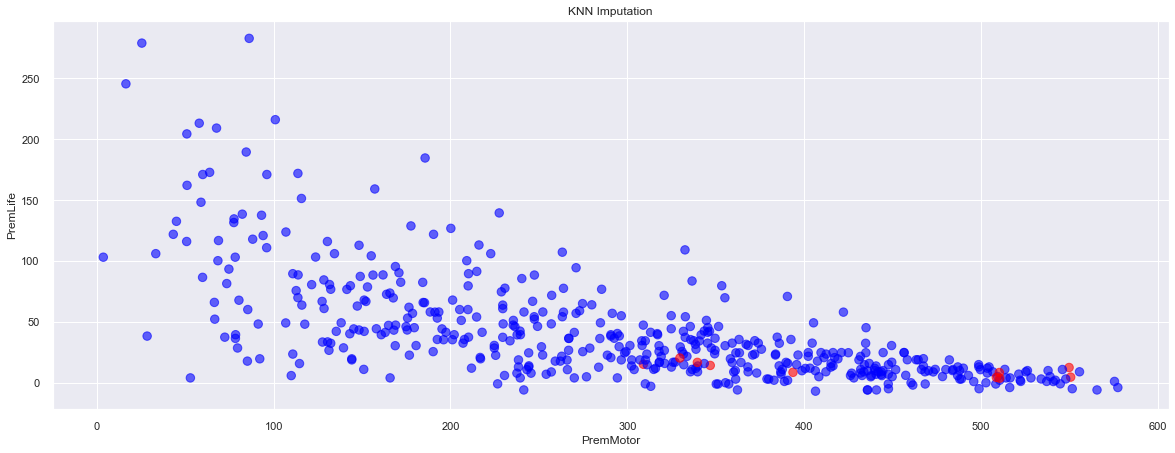

In [1093]:
df_kmeans=df.copy()

le=LabelEncoder()

imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_kmeans[metric_features] = imputer.fit_transform(df_kmeans[metric_features])

dict_educdeg = {b'3 - BSc/MSc' : 3,  b'2 - High School' : 2, b'1 - Basic': 1 , b'4 - PhD': 4}
df_kmeans.replace({"EducDeg": dict_educdeg}, inplace=True)

# df_kmeans['EducDeg']=df_kmeans['EducDeg'].astype(int)

df_kmeans[non_metric_features] = imputer.fit_transform(df_kmeans[non_metric_features])

#round new values to one of the labels
df_kmeans['EducDeg']=df_kmeans['EducDeg'].round(0)
df_kmeans['Children']=df_kmeans['Children'].round(0)
df_kmeans['GeoLivArea']=df_kmeans['GeoLivArea'].round(0)


dict_educdeg = {3 : b'3 - BSc/MSc', 2: b'2 - High School',1 :  b'1 - Basic' , 4 : b'4 - PhD'}
df_kmeans.replace({"EducDeg": dict_educdeg}, inplace=True)


# Scatter plot

fig = plt.Figure()
null_values = df['PremLife'].isnull()
fig = df_kmeans[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='KNN Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)


### - Using linear interpolation for both metric and non metric:

In [1094]:
# df_interpolation=df.copy()
# # Imputing with linear interpolation
# linear_interpolation = df_interpolation.interpolate(method='linear')

# # Plot imputed data

# linear_interpolation['PremLife'][4020:4502].plot(color='red', marker='o', linestyle='dotted')
# df_interpolation['PremLife'][4020:4502].plot(title='PremLife', marker='o', figsize=(35,7))

In [1095]:
df_filled=df_kmeans.copy()

In [1096]:
#convert some variables to int
df_filled = df_filled.astype({'FirstPolYear': int, 'BirthYear': int, 'MonthSal': int , 'GeoLivArea': int, 'Children': int})
#convert index to int
df_filled.index = df_filled.index.astype(int)

In [1097]:
df_filled.sample(5)

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                      
8003            1984       1966      b'3 - BSc/MSc'      2368           4   
4820            1997       1992      b'3 - BSc/MSc'      1291           1   
2975            1993       1968  b'2 - High School'      2728           3   
305             1995       1982      b'3 - BSc/MSc'      2095           3   
9695            1981       1969  b'2 - High School'      2068           1   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
8003           1      -27.20        1.00     468.42          -1.10   
4820           1     1159.23        0.11     104.24         926.85   
2975           1       -7.11        0.98     485.87         118.90   
305            1      -20.00        0.99     434.08          40.00   
9695           0      246.16        0.58     161.03          73.90   

        PremHealth  PremLife  PremWork  
CustID                                  
8003         91.35     13.78      8.78  
4820        146.25     78.46     74.68  
2975         73.68     20.67     17.89  
305         137.47     15.78     20.78  
9695        279.72     90.24     36.23

In [1098]:
#Check if Nans were all filled
df_filled.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [1099]:
# print columns with Nans
nans_index = df.isna().any(axis=1)
df[nans_index]

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                       
22.0           1977.0     1958.0  b'2 - High School'       NaN         3.0   
69.0           1983.0     1977.0  b'2 - High School'    1399.0         4.0   
139.0          1979.0     1976.0  b'2 - High School'    2538.0         2.0   
144.0          1996.0     1990.0      b'3 - BSc/MSc'       NaN         4.0   
185.0          1993.0     1984.0  b'2 - High School'    2419.0         4.0   
...               ...        ...                 ...       ...         ...   
10011.0           NaN     1947.0  b'2 - High School'    3959.0         2.0   
10058.0        1983.0     1980.0  b'2 - High School'    1569.0         4.0   
10143.0        1986.0     1985.0      b'3 - BSc/MSc'    1652.0         3.0   
10285.0        1980.0     1987.0      b'3 - BSc/MSc'    1504.0         4.0   
10286.0        1985.0     1948.0      b'3 - BSc/MSc'    3878.0         4.0   

         Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                                
22.0          1.0      111.37        0.80     407.52         111.70   
69.0          1.0      476.65        0.33     330.73         186.70   
139.0         1.0      149.59        0.69     194.26         305.60   
144.0         1.0      -42.45        1.02     146.36         353.95   
185.0         1.0      -62.23        1.07        NaN         253.95   
...           ...         ...         ...        ...            ...   
10011.0       NaN     -128.24        1.14     177.81         153.35   
10058.0       1.0      222.60        0.55     235.60         211.15   
10143.0       1.0       55.67        0.88     257.05          94.45   
10285.0       1.0       -1.55        0.96     390.63          29.45   
10286.0       1.0      -57.45        1.04     269.05         217.25   

         PremHealth  PremLife  PremWork  
CustID                                   
22.0         100.13     24.67     30.34  
69.0         211.15       NaN     15.78  
139.0           NaN     37.34     17.67  
144.0        220.04    121.80     42.01  
185.0        230.60      5.89     43.12  
...             ...       ...       ...  
10011.0      311.28     67.79     35.45  
10058.0         NaN     32.34     68.79  
10143.0      308.39       NaN     13.78  
10285.0      179.70     -6.00       NaN  
10286.0      219.93     32.45       NaN  

[309 rows x 13 columns]

In [1100]:
#print the same columns with Nans filled
df_filled[nans_index]

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                      
22              1977       1958  b'2 - High School'      2541           3   
69              1983       1977  b'2 - High School'      1399           4   
139             1979       1976  b'2 - High School'      2538           2   
144             1996       1990      b'3 - BSc/MSc'      1721           4   
185             1993       1984  b'2 - High School'      2419           4   
...              ...        ...                 ...       ...         ...   
10011           1990       1947  b'2 - High School'      3959           2   
10058           1983       1980  b'2 - High School'      1569           4   
10143           1986       1985      b'3 - BSc/MSc'      1652           3   
10285           1980       1987      b'3 - BSc/MSc'      1504           4   
10286           1985       1948      b'3 - BSc/MSc'      3878           4   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
22             1      111.37        0.80    407.520         111.70   
69             1      476.65        0.33    330.730         186.70   
139            1      149.59        0.69    194.260         305.60   
144            1      -42.45        1.02    146.360         353.95   
185            1      -62.23        1.07    264.428         253.95   
...          ...         ...         ...        ...            ...   
10011          1     -128.24        1.14    177.810         153.35   
10058          1      222.60        0.55    235.600         211.15   
10143          1       55.67        0.88    257.050          94.45   
10285          1       -1.55        0.96    390.630          29.45   
10286          1      -57.45        1.04    269.050         217.25   

        PremHealth  PremLife  PremWork  
CustID                                  
22         100.130    24.670    30.340  
69         211.150    33.784    15.780  
139        226.598    37.340    17.670  
144        220.040   121.800    42.010  
185        230.600     5.890    43.120  
...            ...       ...       ...  
10011      311.280    67.790    35.450  
10058      247.602    32.340    68.790  
10143      308.390    23.338    13.780  
10285      179.700    -6.000    15.736  
10286      219.930    32.450    41.830  

[309 rows x 13 columns]

In [1101]:
#copy to df
df=df_filled.copy()

In [1102]:
#convert birth year to age
df['Age'] = 2016-df['BirthYear']
df.drop(columns='BirthYear', inplace=True)

#remove from metric_features list
metric_features.remove('BirthYear')

#add age to metric_features list
metric_features.append('Age')

In [1103]:
# print of unique values to check coherence
for col in df[non_metric_features]:
    print('\033[1;3mUnique values of "' + col + '"\033[0m ')
    print(df[col].unique())
    print('\n')

Unique values of "EducDeg" 
[b'2 - High School' b'1 - Basic' b'3 - BSc/MSc' b'4 - PhD']


Unique values of "Children" 
[1 0]


Unique values of "GeoLivArea" 
[1 4 3 2]




<AxesSubplot: xlabel='GeoLivArea', ylabel='count'>

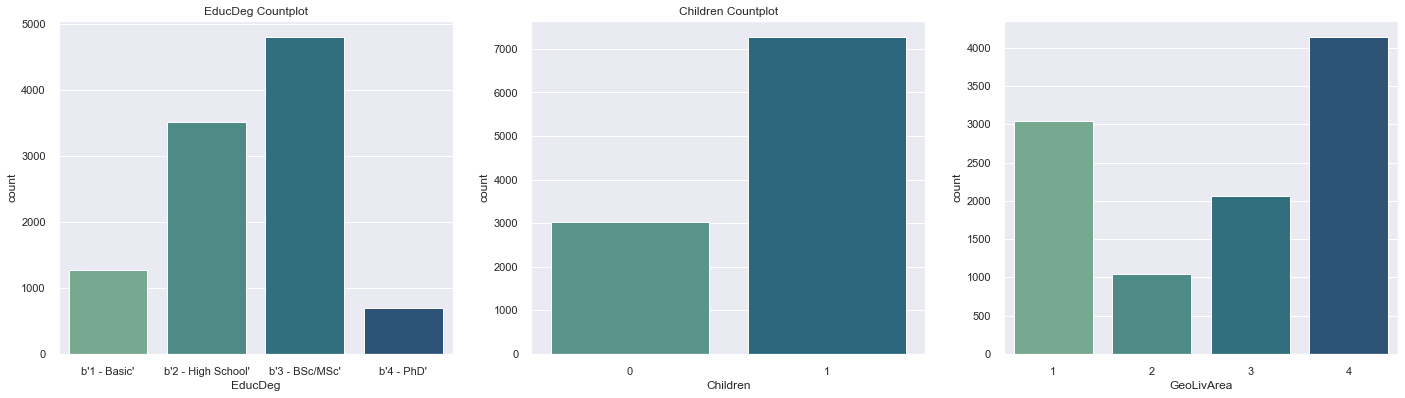

In [1104]:
fig, ax = plt.subplots(1,3, figsize=(24,6))
ax[0].title.set_text('EducDeg Countplot')
ax[1].title.set_text('Children Countplot')
sns.countplot(data=df, x="EducDeg", ax=ax[0], palette='crest', order=df.EducDeg.value_counts().index.sort_values(), dodge=False)
sns.countplot(data=df, x="Children", ax=ax[1], palette='crest',  dodge=False)
sns.countplot(data=df, x="GeoLivArea", ax=ax[2], palette='crest',  dodge=False)


In [1105]:
df.describe(include='all').T

count unique             top  freq         mean          std  \
FirstPolYear   10293.0    NaN             NaN   NaN  1991.049062   510.596931   
EducDeg          10293      4  b'3 - BSc/MSc'  4808          NaN          NaN   
MonthSal       10293.0    NaN             NaN   NaN   2506.40921  1156.183192   
GeoLivArea     10293.0    NaN             NaN   NaN     2.709414     1.266241   
Children       10293.0    NaN             NaN   NaN     0.706597     0.455344   
CustMonVal     10293.0    NaN             NaN   NaN   177.929963  1946.091554   
ClaimsRate     10293.0    NaN             NaN   NaN     0.742728     2.917385   
PremMotor      10293.0    NaN             NaN   NaN   300.702459    211.67798   
PremHousehold  10293.0    NaN             NaN   NaN   210.419863   352.635041   
PremHealth     10293.0    NaN             NaN   NaN   171.596339   295.845039   
PremLife       10293.0    NaN             NaN   NaN    41.616451    47.353344   
PremWork       10293.0    NaN             NaN   NaN    41.155432    51.381233   
Age            10293.0    NaN             NaN   NaN    47.994365     19.70243   

                     min     25%     50%     75%       max  
FirstPolYear      1974.0  1980.0  1986.0  1992.0   53784.0  
EducDeg              NaN     NaN     NaN     NaN       NaN  
MonthSal           333.0  1706.0  2501.0  3290.0   55215.0  
GeoLivArea           1.0     1.0     3.0     4.0       4.0  
Children             0.0     0.0     1.0     1.0       1.0  
CustMonVal    -165680.42   -9.44  187.03  399.86  11875.89  
ClaimsRate           0.0    0.39    0.72    0.98     256.2  
PremMotor          -4.11  191.26  299.28   408.3  11604.42  
PremHousehold      -75.0   49.45   132.8  290.05   25048.8  
PremHealth         -2.11  111.91  162.92  219.04   28272.0  
PremLife            -7.0    9.89   25.45   57.01     398.3  
PremWork           -12.0   10.67   25.67   56.12    1988.7  
Age                 15.0    33.0    48.0    63.0     988.0

In [1106]:
df.describe().round(2).T

count     mean      std        min      25%      50%  \
FirstPolYear   10293.0  1991.05   510.60    1974.00  1980.00  1986.00   
MonthSal       10293.0  2506.41  1156.18     333.00  1706.00  2501.00   
GeoLivArea     10293.0     2.71     1.27       1.00     1.00     3.00   
Children       10293.0     0.71     0.46       0.00     0.00     1.00   
CustMonVal     10293.0   177.93  1946.09 -165680.42    -9.44   187.03   
ClaimsRate     10293.0     0.74     2.92       0.00     0.39     0.72   
PremMotor      10293.0   300.70   211.68      -4.11   191.26   299.28   
PremHousehold  10293.0   210.42   352.64     -75.00    49.45   132.80   
PremHealth     10293.0   171.60   295.85      -2.11   111.91   162.92   
PremLife       10293.0    41.62    47.35      -7.00     9.89    25.45   
PremWork       10293.0    41.16    51.38     -12.00    10.67    25.67   
Age            10293.0    47.99    19.70      15.00    33.00    48.00   

                   75%       max  
FirstPolYear   1992.00  53784.00  
MonthSal       3290.00  55215.00  
GeoLivArea        4.00      4.00  
Children          1.00      1.00  
CustMonVal      399.86  11875.89  
ClaimsRate        0.98    256.20  
PremMotor       408.30  11604.42  
PremHousehold   290.05  25048.80  
PremHealth      219.04  28272.00  
PremLife         57.01    398.30  
PremWork         56.12   1988.70  
Age              63.00    988.00

### Analysis before outliers

In [1107]:
def box_plot_all_vars(data):
    # All Numeric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(4, ceil(len(metric_features) / 4), figsize=(25, 20))

    # Plot data
    # Iterate across axes objects and associate each box plot (hint: use the ax argument):
    for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
        bxplot = sns.boxplot(x=data[feat], ax=ax, color='chartreuse', fliersize=8)
        bxplot.set_xlabel(fontsize=16, xlabel=feat)

    
        
    # Layout
    # Add a centered title to the figure:
    title = "Numeric Variables' Box Plots"

    plt.suptitle(title, size=30)

    plt.show()

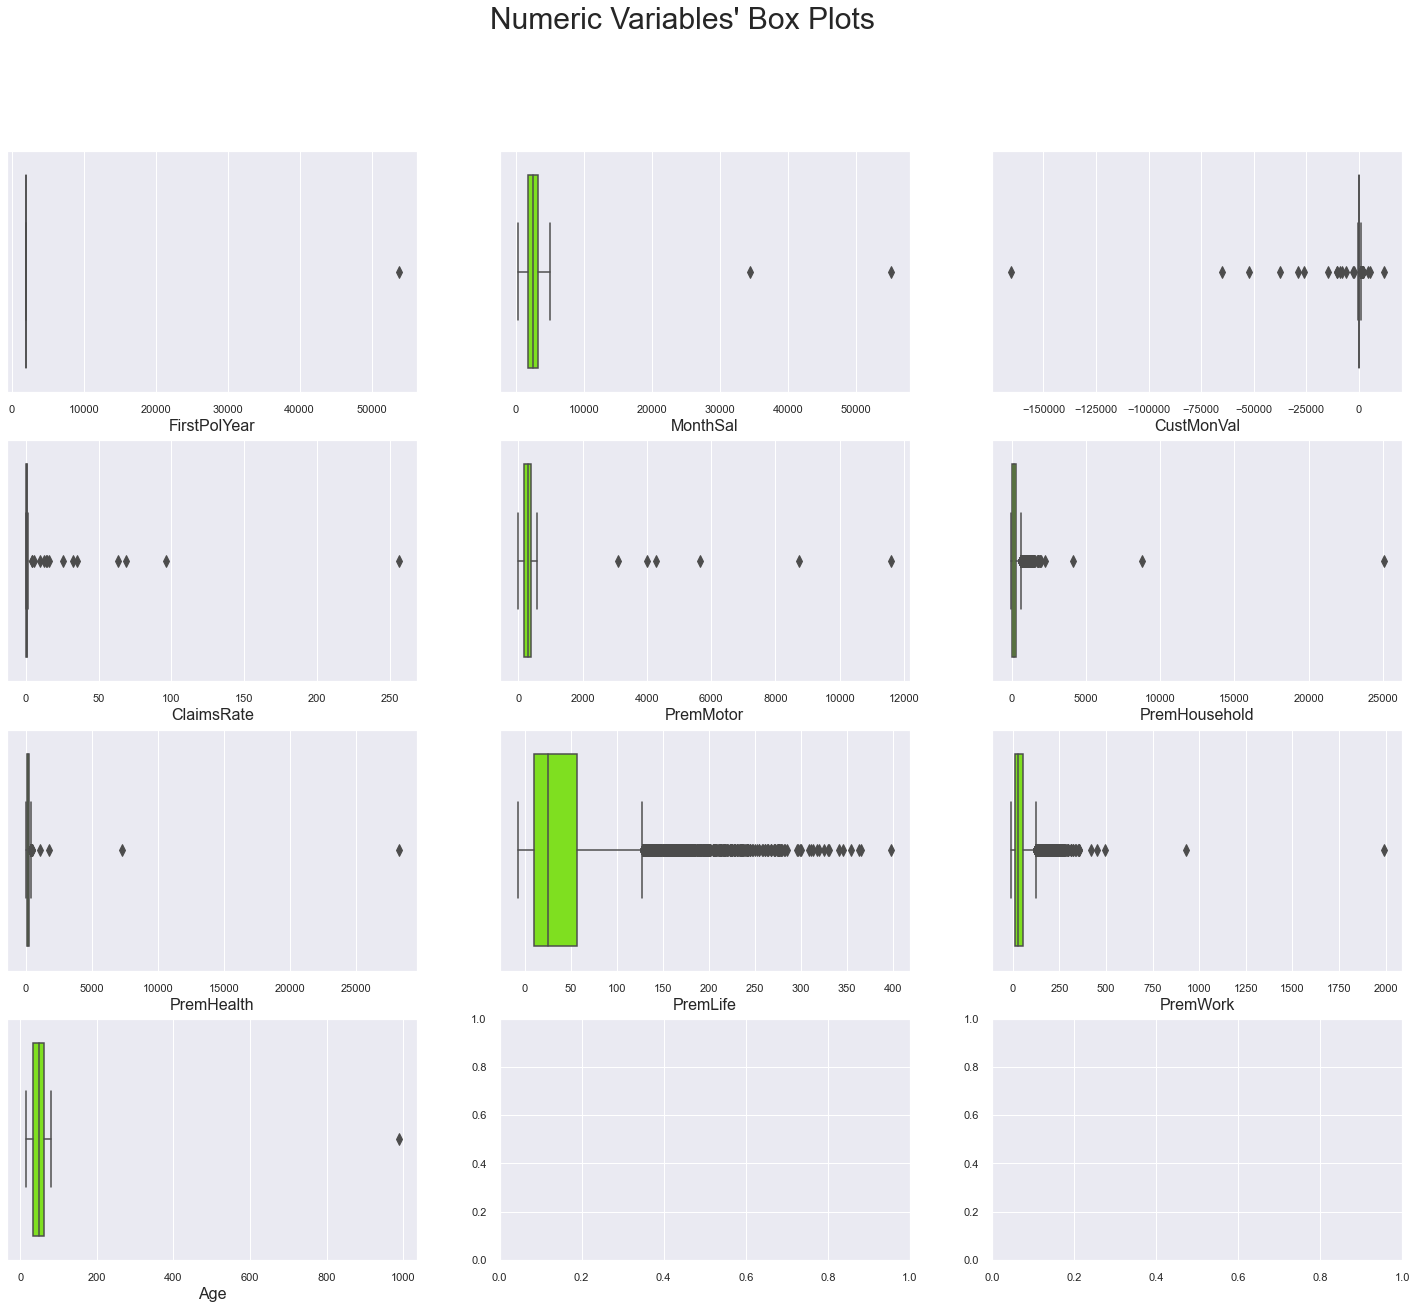

In [1108]:
box_plot_all_vars(df)

### Observation method


In [1109]:
##Following quartiles
filters1 = (
    (df['FirstPolYear']<=2016)
    &
    (df['MonthSal']<=5500)
    &
    (df['CustMonVal']>=-3000)
    &
    (df['CustMonVal']<=3000)
    &
    (df['ClaimsRate']<=6)
    &
    (df['PremMotor']<=700)
    &
    (df['PremHousehold']<=1500)
    &
    (df['PremHealth']<=760)
    &
    (df['PremLife']<=150)
    &
    (df['Age']<=85)
)

df_1 = df[filters1]
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9553


In [1110]:
# df_3['FirstPolYear'].unique()

### IQR method


In [1111]:
##IQR method
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df[metric].between(llim, ulim, inclusive='both'))

filters2 = pd.Series(np.all(filters2, 0))
df_2=df.copy()
df_2['filters2'] = filters2.to_list()
df_2=df_2[df_2['filters2']!=False]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.8541


### Combining Both

In [1112]:
##Combining the 2 above
df_3 = df.copy()
df_3['filters1'] = filters1.to_list()
df_3['filters2'] = filters2
df_3 = df_3[(df_3['filters1']==True) | (df_3['filters2']==True)]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9947


### Observation method more conservative

In [1113]:
##Removing more critical data points
filters3 = (
    (df['FirstPolYear']<=2016)
    &
    (df['MonthSal']<=30000)
    &
    (df['CustMonVal']>=-75000)
    &
    (df['ClaimsRate']<=100)
    &
    (df['PremMotor']<=6000)
    &
    (df['PremHousehold']<=5000)
    &
    (df['PremHealth']<=5000)
    &
    (df['PremLife']<=398)
    &
    (df['Age']<=85)
)

df_4 = df[filters3]
print('Percentage of data kept after removing outliers:', np.round(df_4.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9988


In [1114]:
## print para comparar os dois metodos de outliers, e colocar que se escolheu so usar o manual
df_3.drop(columns=['filters1','filters2'], inplace=True)
print('Data shape before outliers removal:')
print(df.shape)
print('Data shape after outliers removal:')
print('df_1: ', df_1.shape)
print('df_2: ', df_2.shape)
print('df_3: ', df_3.shape)
print('df_4: ', df_4.shape)

Data shape before outliers removal:
(10293, 13)
Data shape after outliers removal:
df_1:  (9833, 13)
df_2:  (8791, 14)
df_3:  (10238, 13)
df_4:  (10281, 13)


In [1115]:
# df=df_1.copy()
df=df_3.copy()

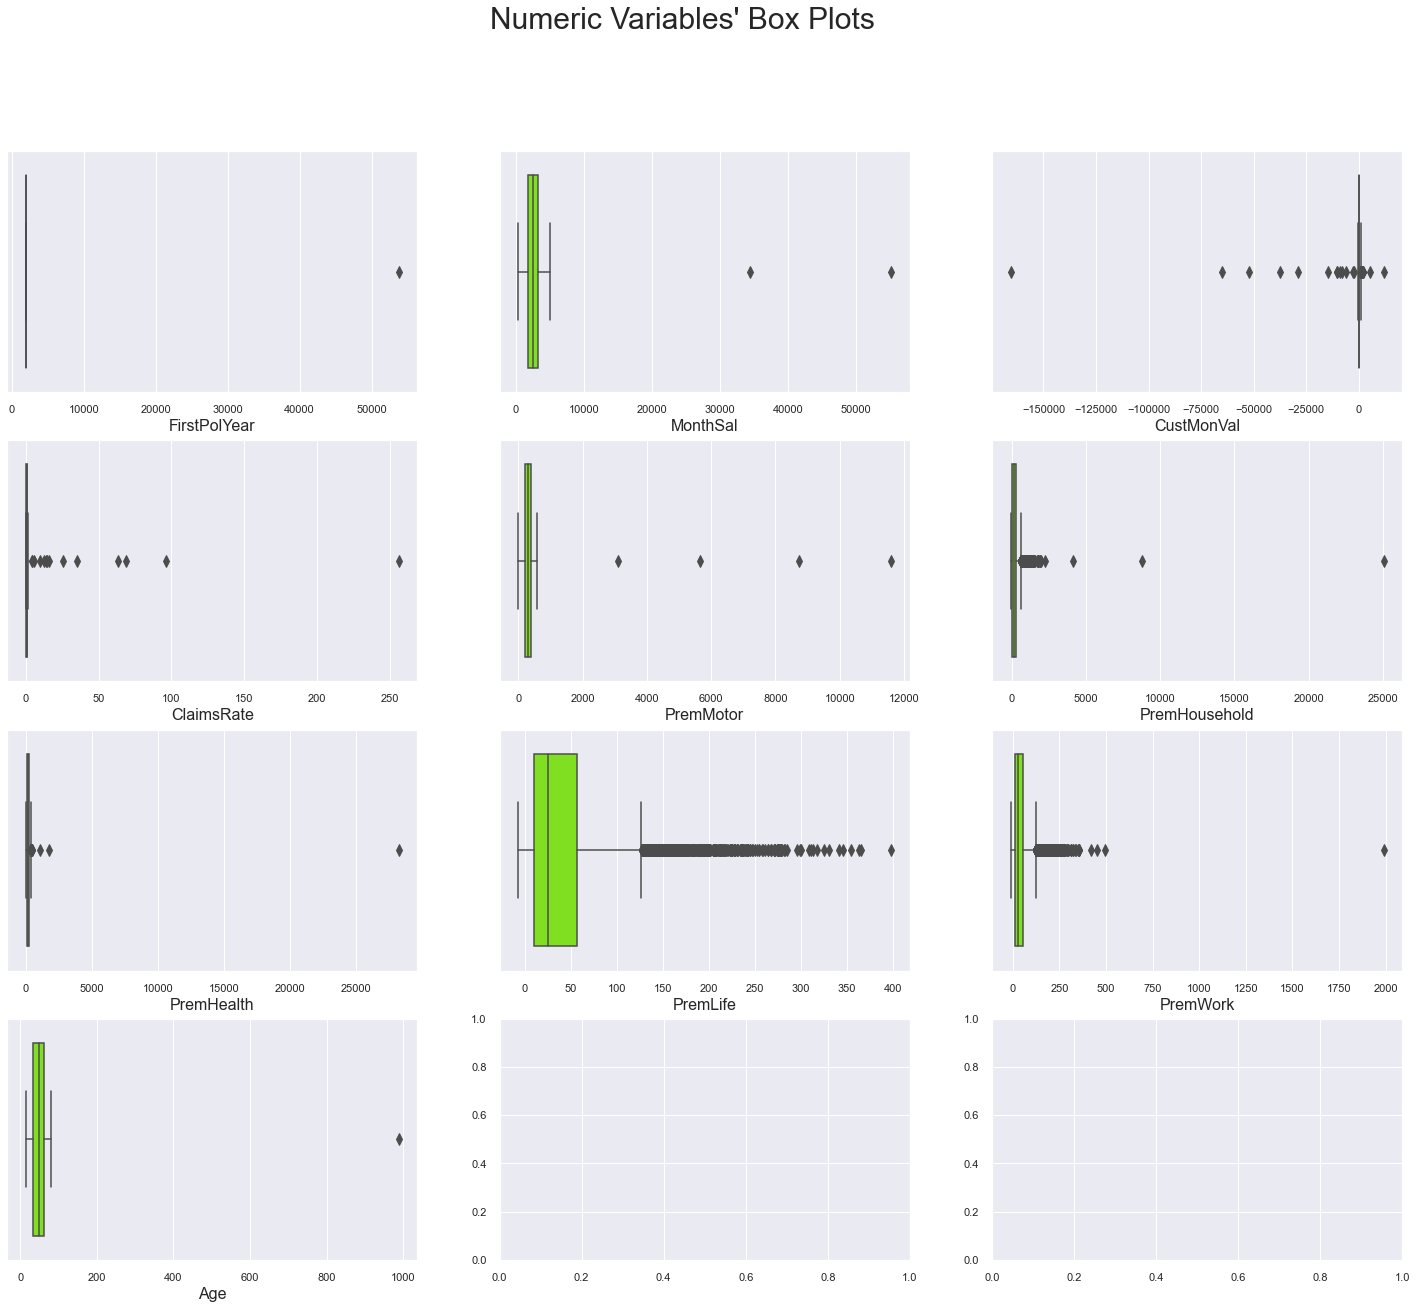

In [1116]:
box_plot_all_vars(df)

In [1117]:
df['FirstPolYear'].unique()

array([ 1985,  1981,  1991,  1990,  1986,  1979,  1988,  1976,  1983,
        1977,  1998,  1974,  1978,  1995,  1980,  1984,  1989,  1987,
        1982,  1994,  1993,  1992,  1997,  1996,  1975, 53784])

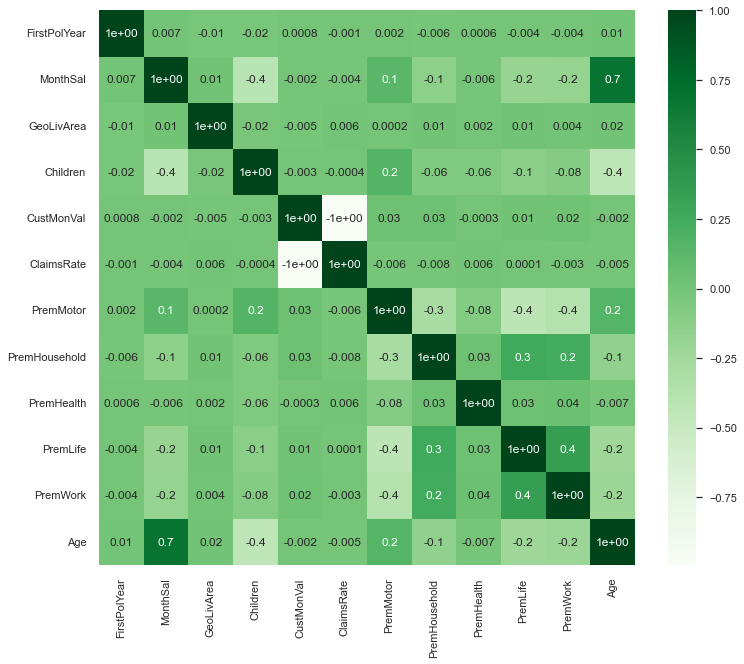

In [1118]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Greens, fmt='.1')
    plt.show()
cor_pearson = df.corr()
cor_heatmap(cor_pearson)


In [1119]:
##Drop columns with very high correlations
# df.drop(columns=['MonthSal','CustMonVal'], inplace=True)
df.drop(columns=['CustMonVal'], inplace=True)
# metric_features.remove('MonthSal')
metric_features.remove('CustMonVal')

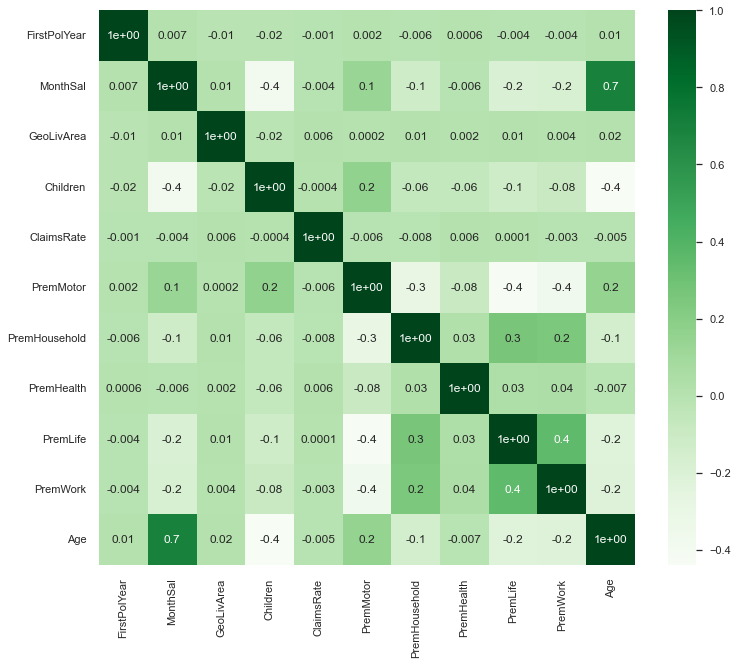

In [1120]:
cor_pearson = df.corr()
cor_heatmap(cor_pearson)

In [1121]:
df[metric_features].sample(5)

FirstPolYear  MonthSal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                                 
1141            1989      3524        0.99     330.95          69.45   
6062            1988      3472        0.32     244.60         373.95   
4588            1977      2097        0.31     230.82         442.30   
3826            1996      1079        0.93     327.95          63.35   
5343            1988      2980        1.01     361.18           4.45   

        PremHealth  PremLife  PremWork  Age  
CustID                                       
1141        236.49      6.78      1.89   62  
6062        234.49      2.00     52.12   62  
4588        242.38     25.56     -3.11   36  
3826        178.59     -4.00     52.79   37  
5343        189.37     11.67     10.89   61

In [1122]:
df_not_scaled = df.copy()

### MinMaxScaler

In [1123]:
df_minmax=df.copy()
#normalize with minmaxscaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_minmax[metric_features])
df_minmax[metric_features] = scaled_features

df_minmax.describe().T

count      mean       std  min       25%       50%       75%  \
FirstPolYear   10238.0  0.000330  0.009882  0.0  0.000116  0.000232  0.000347   
MonthSal       10238.0  0.039682  0.021043  0.0  0.025163  0.039558  0.053893   
GeoLivArea     10238.0  2.710197  1.265990  1.0  1.000000  3.000000  4.000000   
Children       10238.0  0.707365  0.454995  0.0  0.000000  1.000000  1.000000   
ClaimsRate     10238.0  0.002887  0.011352  0.0  0.001522  0.002810  0.003825   
PremMotor      10238.0  0.026289  0.017633  0.0  0.017002  0.026231  0.035543   
PremHousehold  10238.0  0.011308  0.014019  0.0  0.004953  0.008271  0.014486   
PremHealth     10238.0  0.006125  0.010188  0.0  0.004033  0.005837  0.007849   
PremLife       10238.0  0.118080  0.113889  0.0  0.041673  0.080064  0.157112   
PremWork       10238.0  0.026401  0.025207  0.0  0.011331  0.018773  0.033938   
Age            10238.0  0.033997  0.020214  0.0  0.018499  0.033916  0.049332   

               max  
FirstPolYear   1.0  
MonthSal       1.0  
GeoLivArea     4.0  
Children       1.0  
ClaimsRate     1.0  
PremMotor      1.0  
PremHousehold  1.0  
PremHealth     1.0  
PremLife       1.0  
PremWork       1.0  
Age            1.0

### StandartScaler

In [1124]:
df_st_scaler=df.copy()
#normalize with standart scaler
from sklearn.preprocessing import StandardScaler
standart_scaler = StandardScaler()
standart_scaler_features = standart_scaler.fit_transform(df_st_scaler[metric_features])
df_st_scaler[metric_features] = standart_scaler_features

df_st_scaler.describe().T

count          mean       std       min       25%       50%  \
FirstPolYear   10238.0  1.859987e-16  1.000049 -0.033359 -0.021639 -0.009918   
MonthSal       10238.0 -1.110440e-16  1.000049 -1.885854 -0.690003 -0.005917   
GeoLivArea     10238.0  2.710197e+00  1.265990  1.000000  1.000000  3.000000   
Children       10238.0  7.073647e-01  0.454995  0.000000  0.000000  1.000000   
ClaimsRate     10238.0 -1.041037e-17  1.000049 -0.254337 -0.120238 -0.006769   
PremMotor      10238.0  1.651779e-16  1.000049 -1.490954 -0.526708 -0.003327   
PremHousehold  10238.0  9.438739e-17  1.000049 -0.806685 -0.453323 -0.216659   
PremHealth     10238.0 -3.608930e-17  1.000049 -0.601216 -0.205375 -0.028284   
PremLife       10238.0  8.015988e-17  1.000049 -1.036854 -0.670929 -0.333818   
PremWork       10238.0  3.817137e-17  1.000049 -1.047427 -0.597880 -0.302611   
Age            10238.0  1.804465e-17  1.000049 -1.681941 -0.766699 -0.003998   

                    75%         max  
FirstPolYear   0.001802  101.169650  
MonthSal       0.675354   45.638191  
GeoLivArea     4.000000    4.000000  
Children       1.000000    1.000000  
ClaimsRate     0.082630   87.838589  
PremMotor      0.524805   55.222214  
PremHousehold  0.226712   70.529636  
PremHealth     0.169255   97.557594  
PremLife       0.342733    7.744060  
PremWork       0.299032   38.626488  
Age            0.758703   47.791943

### Robust Scaler

In [1125]:
df_robust_scaler=df.copy()
#normalize with robust scaler
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
robust_scaler_features = robust_scaler.fit_transform(df_robust_scaler[metric_features])
df_robust_scaler[metric_features] = robust_scaler_features

df_robust_scaler.describe().T

count      mean        std       min       25%  50%  \
FirstPolYear   10238.0  0.423138  42.663859 -1.000000 -0.500000  0.0   
MonthSal       10238.0  0.004334   0.732445 -1.376883 -0.501031  0.0   
GeoLivArea     10238.0  2.710197   1.265990  1.000000  1.000000  3.0   
Children       10238.0  0.707365   0.454995  0.000000  0.000000  1.0   
ClaimsRate     10238.0  0.033367   4.929550 -1.220339 -0.559322  0.0   
PremMotor      10238.0  0.003164   0.951057 -1.414749 -0.497741  0.0   
PremHousehold  10238.0  0.318601   1.470586 -0.867641 -0.348017  0.0   
PremHealth     10238.0  0.075499   2.669434 -1.529330 -0.472709  0.0   
PremLife       10238.0  0.329319   0.986571 -0.693561 -0.332567  0.0   
PremWork       10238.0  0.337392   1.114991 -0.830422 -0.329206  0.0   
Age            10238.0  0.002621   0.655597 -1.100000 -0.500000  0.0   

                    75%          max  
FirstPolYear   0.500000  4316.500000  
MonthSal       0.498969    33.430157  
GeoLivArea     4.000000     4.000000  
Children       1.000000     1.000000  
ClaimsRate     0.440678   433.016949  
PremMotor      0.502259    52.520089  
PremHousehold  0.651983   104.033403  
PremHealth     0.527291   260.486331  
PremLife       0.667433     7.969009  
PremWork       0.670794    43.403493  
Age            0.500000    31.333333

### Choosing scaler method

In [1126]:
df=df_st_scaler.copy()
df_cat_num = df_st_scaler.copy()
# df=df_robust_scaler.copy()
# df_cat_num = df_robust_scaler.copy()

In [1127]:
df.isna().sum()

FirstPolYear     0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
Age              0
dtype: int64

In [1128]:
df[non_metric_features]

EducDeg  Children  GeoLivArea
CustID                                          
1       b'2 - High School'         1           1
2       b'2 - High School'         1           4
3             b'1 - Basic'         0           3
4           b'3 - BSc/MSc'         1           4
5           b'3 - BSc/MSc'         1           4
...                    ...       ...         ...
10292           b'4 - PhD'         0           2
10293         b'1 - Basic'         0           3
10294       b'3 - BSc/MSc'         1           1
10295         b'1 - Basic'         1           2
10296           b'4 - PhD'         1           1

[10238 rows x 3 columns]

### One Hot Encoder
#### Using standart scaled DF

In [1129]:
##ONE HOT ENCODING
df_ohc = df[non_metric_features].copy()

ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc)
ohc_feat_names = ohc.get_feature_names_out()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
ohc_df.drop(['Children_0'],axis=1, inplace=True)
ohc_df

EducDeg_b'1 - Basic'  EducDeg_b'2 - High School'  \
CustID                                                     
1                        0.0                         1.0   
2                        0.0                         1.0   
3                        1.0                         0.0   
4                        0.0                         0.0   
5                        0.0                         0.0   
...                      ...                         ...   
10292                    0.0                         0.0   
10293                    1.0                         0.0   
10294                    0.0                         0.0   
10295                    1.0                         0.0   
10296                    0.0                         0.0   

        EducDeg_b'3 - BSc/MSc'  EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  \
CustID                                                                         
1                          0.0                 0.0         1.0           1.0   
2                          0.0                 0.0         1.0           0.0   
3                          0.0                 0.0         0.0           0.0   
4                          1.0                 0.0         1.0           0.0   
5                          1.0                 0.0         1.0           0.0   
...                        ...                 ...         ...           ...   
10292                      0.0                 1.0         0.0           0.0   
10293                      0.0                 0.0         0.0           0.0   
10294                      1.0                 0.0         1.0           1.0   
10295                      0.0                 0.0         1.0           0.0   
10296                      0.0                 1.0         1.0           1.0   

        GeoLivArea_2  GeoLivArea_3  GeoLivArea_4  
CustID                                            
1                0.0           0.0           0.0  
2                0.0           0.0           1.0  
3                0.0           1.0           0.0  
4                0.0           0.0           1.0  
5                0.0           0.0           1.0  
...              ...           ...           ...  
10292            1.0           0.0           0.0  
10293            0.0           1.0           0.0  
10294            0.0           0.0           0.0  
10295            1.0           0.0           0.0  
10296            0.0           0.0           0.0  

[10238 rows x 9 columns]

In [1130]:
df_scaled=df.merge(ohc_df, on = 'CustID')
df_scaled.drop(['Children', 'EducDeg', 'GeoLivArea'],axis=1, inplace=True)
df_scaled

FirstPolYear  MonthSal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                                 
1          -0.011872 -0.289077   -0.120238   0.365331      -0.368141   
2          -0.019685 -1.587974    0.130769  -1.092446       0.588024   
3          -0.000152 -0.202484   -0.158061  -0.463734       0.043713   
4          -0.002105 -1.222551    0.086069  -0.579373      -0.470643   
5          -0.009918 -0.647572    0.055123   0.183445      -0.458008   
...              ...       ...         ...        ...            ...   
10292      -0.013825  0.586380    0.075754   0.452732      -0.453323   
10293      -0.027499 -0.069130   -0.254337  -0.818273       2.347170   
10294       0.005708  0.352578   -0.182130   0.501049      -0.216659   
10295      -0.019685 -0.467459   -0.030838  -0.549523       0.005807   
10296      -0.002105  0.263387   -0.161499   0.552103      -0.325550   

        PremHealth  PremLife  PremWork       Age  EducDeg_b'1 - Basic'  \
CustID                                                                   
1        -0.085775  0.133284 -0.474537 -0.715852                   0.0   
2        -0.188780  3.328255  1.295093 -1.376860                   0.0   
3        -0.161388  0.985594  1.154102 -0.105692                   1.0   
4         0.486393 -0.119549 -0.247484 -0.665006                   0.0   
5         0.040004 -0.478325  0.012488 -0.258232                   0.0   
...            ...       ...       ...       ...                   ...   
10292     0.009523 -0.673312 -0.516379  0.962090                   0.0   
10293    -0.096572 -0.605933  1.275263  0.809550                   1.0   
10294    -0.100044 -0.610699 -0.712498 -0.410772                   0.0   
10295     0.094787  0.499210  1.429541 -0.461619                   1.0   
10296    -0.103515 -0.735924 -0.553857 -0.665006                   0.0   

        EducDeg_b'2 - High School'  EducDeg_b'3 - BSc/MSc'  \
CustID                                                       
1                              1.0                     0.0   
2                              1.0                     0.0   
3                              0.0                     0.0   
4                              0.0                     1.0   
5                              0.0                     1.0   
...                            ...                     ...   
10292                          0.0                     0.0   
10293                          0.0                     0.0   
10294                          0.0                     1.0   
10295                          0.0                     0.0   
10296                          0.0                     0.0   

        EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  GeoLivArea_2  \
CustID                                                               
1                      0.0         1.0           1.0           0.0   
2                      0.0         1.0           0.0           0.0   
3                      0.0         0.0           0.0           0.0   
4                      0.0         1.0           0.0           0.0   
5                      0.0         1.0           0.0           0.0   
...                    ...         ...           ...           ...   
10292                  1.0         0.0           0.0           1.0   
10293                  0.0         0.0           0.0           0.0   
10294                  0.0         1.0           1.0           0.0   
10295                  0.0         1.0           0.0           1.0   
10296                  1.0         1.0           1.0           0.0   

        GeoLivArea_3  GeoLivArea_4  
CustID                              
1                0.0           0.0  
2                0.0           1.0  
3                1.0           0.0  
4                0.0           1.0  
5                0.0           1.0  
...              ...           ...  
10292            0.0           0.0  
10293            1.0           0.0  
10294            0.0

#### Using MinMaxScaler

In [1131]:
##ONE HOT ENCODING
df_ohc = df_minmax[non_metric_features].copy()

ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc)
ohc_feat_names = ohc.get_feature_names_out()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
ohc_df.drop(['Children_0'],axis=1, inplace=True)
ohc_df

EducDeg_b'1 - Basic'  EducDeg_b'2 - High School'  \
CustID                                                     
1                        0.0                         1.0   
2                        0.0                         1.0   
3                        1.0                         0.0   
4                        0.0                         0.0   
5                        0.0                         0.0   
...                      ...                         ...   
10292                    0.0                         0.0   
10293                    1.0                         0.0   
10294                    0.0                         0.0   
10295                    1.0                         0.0   
10296                    0.0                         0.0   

        EducDeg_b'3 - BSc/MSc'  EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  \
CustID                                                                         
1                          0.0                 0.0         1.0           1.0   
2                          0.0                 0.0         1.0           0.0   
3                          0.0                 0.0         0.0           0.0   
4                          1.0                 0.0         1.0           0.0   
5                          1.0                 0.0         1.0           0.0   
...                        ...                 ...         ...           ...   
10292                      0.0                 1.0         0.0           0.0   
10293                      0.0                 0.0         0.0           0.0   
10294                      1.0                 0.0         1.0           1.0   
10295                      0.0                 0.0         1.0           0.0   
10296                      0.0                 1.0         1.0           1.0   

        GeoLivArea_2  GeoLivArea_3  GeoLivArea_4  
CustID                                            
1                0.0           0.0           0.0  
2                0.0           0.0           1.0  
3                0.0           1.0           0.0  
4                0.0           0.0           1.0  
5                0.0           0.0           1.0  
...              ...           ...           ...  
10292            1.0           0.0           0.0  
10293            0.0           1.0           0.0  
10294            0.0           0.0           0.0  
10295            1.0           0.0           0.0  
10296            0.0           0.0           0.0  

[10238 rows x 9 columns]

In [1132]:
df_minmax=df_minmax.merge(ohc_df, on = 'CustID')
df_minmax.drop(['Children', 'EducDeg', 'GeoLivArea'],axis=1, inplace=True)
df_minmax

FirstPolYear  MonthSal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                                 
1           0.000212  0.033599    0.001522   0.032731       0.006148   
2           0.000135  0.006268    0.004372   0.007027       0.019551   
3           0.000328  0.035421    0.001093   0.018113       0.011921   
4           0.000309  0.013957    0.003864   0.016074       0.004711   
5           0.000232  0.026056    0.003513   0.029524       0.004888   
...              ...       ...         ...        ...            ...   
10292       0.000193  0.052021    0.003747   0.034272       0.004953   
10293       0.000058  0.038227    0.000000   0.011861       0.044211   
10294       0.000386  0.047101    0.000820   0.035124       0.008271   
10295       0.000135  0.029846    0.002537   0.016600       0.011390   
10296       0.000309  0.045224    0.001054   0.036024       0.006745   

        PremHealth  PremLife  PremWork       Age  EducDeg_b'1 - Basic'  \
CustID                                                                   
1         0.005251  0.133259  0.014440  0.019527                   0.0   
2         0.004202  0.497113  0.059044  0.006166                   0.0   
3         0.004481  0.230323  0.055491  0.031860                   1.0   
4         0.011080  0.104466  0.020163  0.020555                   0.0   
5         0.006532  0.063607  0.026716  0.028777                   0.0   
...            ...       ...       ...       ...                   ...   
10292     0.006222  0.041401  0.013385  0.053443                   0.0   
10293     0.005141  0.049075  0.058545  0.050360                   1.0   
10294     0.005106  0.048532  0.008442  0.025694                   0.0   
10295     0.007091  0.174932  0.062433  0.024666                   1.0   
10296     0.005070  0.034271  0.012441  0.020555                   0.0   

        EducDeg_b'2 - High School'  EducDeg_b'3 - BSc/MSc'  \
CustID                                                       
1                              1.0                     0.0   
2                              1.0                     0.0   
3                              0.0                     0.0   
4                              0.0                     1.0   
5                              0.0                     1.0   
...                            ...                     ...   
10292                          0.0                     0.0   
10293                          0.0                     0.0   
10294                          0.0                     1.0   
10295                          0.0                     0.0   
10296                          0.0                     0.0   

        EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  GeoLivArea_2  \
CustID                                                               
1                      0.0         1.0           1.0           0.0   
2                      0.0         1.0           0.0           0.0   
3                      0.0         0.0           0.0           0.0   
4                      0.0         1.0           0.0           0.0   
5                      0.0         1.0           0.0           0.0   
...                    ...         ...           ...           ...   
10292                  1.0         0.0           0.0           1.0   
10293                  0.0         0.0           0.0           0.0   
10294                  0.0         1.0           1.0           0.0   
10295                  0.0         1.0           0.0           1.0   
10296                  1.0         1.0           1.0           0.0   

        GeoLivArea_3  GeoLivArea_4  
CustID                              
1                0.0           0.0  
2                0.0           1.0  
3                1.0           0.0  
4                0.0           1.0  
5                0.0           1.0  
...              ...           ...  
10292            0.0           0.0  
10293            1.0           0.0  
10294            0.0

### Keep one hot from standart scaler

In [1133]:
df=df_scaled.copy()
df

FirstPolYear  MonthSal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                                 
1          -0.011872 -0.289077   -0.120238   0.365331      -0.368141   
2          -0.019685 -1.587974    0.130769  -1.092446       0.588024   
3          -0.000152 -0.202484   -0.158061  -0.463734       0.043713   
4          -0.002105 -1.222551    0.086069  -0.579373      -0.470643   
5          -0.009918 -0.647572    0.055123   0.183445      -0.458008   
...              ...       ...         ...        ...            ...   
10292      -0.013825  0.586380    0.075754   0.452732      -0.453323   
10293      -0.027499 -0.069130   -0.254337  -0.818273       2.347170   
10294       0.005708  0.352578   -0.182130   0.501049      -0.216659   
10295      -0.019685 -0.467459   -0.030838  -0.549523       0.005807   
10296      -0.002105  0.263387   -0.161499   0.552103      -0.325550   

        PremHealth  PremLife  PremWork       Age  EducDeg_b'1 - Basic'  \
CustID                                                                   
1        -0.085775  0.133284 -0.474537 -0.715852                   0.0   
2        -0.188780  3.328255  1.295093 -1.376860                   0.0   
3        -0.161388  0.985594  1.154102 -0.105692                   1.0   
4         0.486393 -0.119549 -0.247484 -0.665006                   0.0   
5         0.040004 -0.478325  0.012488 -0.258232                   0.0   
...            ...       ...       ...       ...                   ...   
10292     0.009523 -0.673312 -0.516379  0.962090                   0.0   
10293    -0.096572 -0.605933  1.275263  0.809550                   1.0   
10294    -0.100044 -0.610699 -0.712498 -0.410772                   0.0   
10295     0.094787  0.499210  1.429541 -0.461619                   1.0   
10296    -0.103515 -0.735924 -0.553857 -0.665006                   0.0   

        EducDeg_b'2 - High School'  EducDeg_b'3 - BSc/MSc'  \
CustID                                                       
1                              1.0                     0.0   
2                              1.0                     0.0   
3                              0.0                     0.0   
4                              0.0                     1.0   
5                              0.0                     1.0   
...                            ...                     ...   
10292                          0.0                     0.0   
10293                          0.0                     0.0   
10294                          0.0                     1.0   
10295                          0.0                     0.0   
10296                          0.0                     0.0   

        EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  GeoLivArea_2  \
CustID                                                               
1                      0.0         1.0           1.0           0.0   
2                      0.0         1.0           0.0           0.0   
3                      0.0         0.0           0.0           0.0   
4                      0.0         1.0           0.0           0.0   
5                      0.0         1.0           0.0           0.0   
...                    ...         ...           ...           ...   
10292                  1.0         0.0           0.0           1.0   
10293                  0.0         0.0           0.0           0.0   
10294                  0.0         1.0           1.0           0.0   
10295                  0.0         1.0           0.0           1.0   
10296                  1.0         1.0           1.0           0.0   

        GeoLivArea_3  GeoLivArea_4  
CustID                              
1                0.0           0.0  
2                0.0           1.0  
3                1.0           0.0  
4                0.0           1.0  
5                0.0           1.0  
...              ...           ...  
10292            0.0           0.0  
10293            1.0           0.0  
10294            0.0

In [1134]:
# ProfileReport(
#     df,
#     title='Data Preprocessed Analysis',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

## PCA
#### Using standart scaler df

In [1135]:
# ##PCA
# df_pca = df.copy()


# pca = PCA()
# pca_feat = pca.fit_transform(df_pca[metric_features])

In [1136]:
# pd.DataFrame(
#     {"Eigenvalue": pca.explained_variance_,
#      "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
#      "Proportion": pca.explained_variance_ratio_,
#      "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
#     index=range(1, pca.n_components_ + 1)
# )

##### We can notice that only a reduction to 5 components (~82%) would be representative of the data set. Since originally, we had 13 features, it doesn't make sense to keep 5 components.
#### Let's try with the df from min max scaler...


In [1137]:
# ##PCA
# df_pca_min_max = df_minmax.copy()


# pca_min_max = PCA()
# pca_feat_min_max = pca_min_max.fit_transform(df_pca_min_max[metric_features])

In [1138]:
# pd.DataFrame(
#     {"Eigenvalue": pca_min_max.explained_variance_,
#      "Difference": np.insert(np.diff(pca_min_max.explained_variance_), 0, 0),
#      "Proportion": pca_min_max.explained_variance_ratio_,
#      "Cumulative": np.cumsum(pca_min_max.explained_variance_ratio_)},
#     index=range(1, pca_min_max.n_components_ + 1)
# )

##### Now it's clear that with only 3 components, we have 90% of explained variance
##### Let's keep this DF to visualize PCA

In [1139]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


# ax1.plot(pca_min_max.explained_variance_, marker=".", markersize=12)
# ax2.plot(pca_min_max.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
# ax2.plot(np.cumsum(pca_min_max.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")


# ax2.legend()
# ax1.set_title("Scree Plot", fontsize=14)
# ax2.set_title("Variance Explained", fontsize=14)
# ax1.set_ylabel("Eigenvalue")
# ax2.set_ylabel("Proportion")
# ax1.set_xlabel("Components")
# ax2.set_xlabel("Components")
# ax1.set_xticks(range(0, pca_min_max.n_components_, 2))
# ax1.set_xticklabels(range(1, pca_min_max.n_components_ + 1, 2))
# ax2.set_xticks(range(0, pca_min_max.n_components_, 2))
# ax2.set_xticklabels(range(1, pca_min_max.n_components_ + 1, 2))

# plt.show()

In [1140]:
# pca_min_max = PCA(n_components=3)
# pca_feat_min_max = pca_min_max.fit_transform(df_pca_min_max[metric_features])
# pca_feat_names = [f"PC{i}" for i in range(pca_min_max.n_components_)]
# pca_df = pd.DataFrame(pca_feat_min_max, index=df_pca_min_max.index, columns=pca_feat_names) 
# pca_df

In [1141]:
# df_pca_min_max = pd.concat([df_pca_min_max, pca_df], axis=1)
# df_pca_min_max.head()

In [1142]:
# def _color_red_or_green(val):
#     if val < -0.45:
#         color = 'background-color: red'
#     elif val > 0.45:
#         color = 'background-color: green'
#     else:
#         color = ''
#     return color
    


# # Interpreting each Principal Component
# loadings = df_pca_min_max[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
# loadings.style.applymap(_color_red_or_green)

In [1143]:
# df_pca_min_max['HighScore'] = df_pca_min_max[['PC0', 'PC1', 'PC2']].idxmax(axis=1)
# df_pca_min_max

### At this point, we have 2 different Dataframes. One from min max scaler with 3 Principal components. And another from standart scaler without PCA.
#### Let's see wich one performs best when doing clustering

In [1144]:
# df_pca_min_max.head()

In [1145]:
# df = df_pca.copy()
# df.head()

# NEW

---
### Splitting variables perspectives

#### - Removing DBSCAN outliers

In [1146]:
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[metric_features])
Counter(dbscan_labels)

Counter({0: 10211, -1: 27})

In [1147]:
# Save the newly detected outliers (they will be classified later based on the final clusters)
df_out = df[dbscan_labels==-1].copy()

# New df without outliers and 'rcn'
df = df[dbscan_labels!=-1]\
    .copy()

df_cat_num = df_cat_num[df_cat_num.index.isin(df.index)]
df_not_scaled = df_not_scaled[df_not_scaled.index.isin(df.index)]


In [1148]:
df_not_scaled

FirstPolYear             EducDeg  MonthSal  GeoLivArea  Children  \
CustID                                                                     
1               1985  b'2 - High School'      2177           1         1   
2               1981  b'2 - High School'       677           4         1   
3               1991        b'1 - Basic'      2277           3         0   
4               1990      b'3 - BSc/MSc'      1099           4         1   
5               1986      b'3 - BSc/MSc'      1763           4         1   
...              ...                 ...       ...         ...       ...   
10292           1984          b'4 - PhD'      3188           2         0   
10293           1977        b'1 - Basic'      2431           3         0   
10294           1994      b'3 - BSc/MSc'      2918           1         1   
10295           1981        b'1 - Basic'      1971           2         1   
10296           1990          b'4 - PhD'      2815           1         1   

        ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
CustID                                                                         
1             0.39     375.85          79.45      146.36     47.01     16.89   
2             1.12      77.46         416.20      116.69    194.48    106.13   
3             0.28     206.15         224.50      124.58     86.35     99.02   
4             0.99     182.48          43.35      311.17     35.34     28.34   
5             0.90     338.62          47.80      182.59     18.78     41.45   
...            ...        ...            ...         ...       ...       ...   
10292         0.96     393.74          49.45      173.81      9.78     14.78   
10293         0.00     133.58        1035.75      143.25     12.89    105.13   
10294         0.21     403.63         132.80      142.25     12.67      4.89   
10295         0.65     188.59         211.15      198.37     63.90    112.91   
10296         0.27     414.08          94.45      141.25      6.89     12.89   

        Age  
CustID       
1        34  
2        21  
3        46  
4        35  
5        43  
...     ...  
10292    67  
10293    64  
10294    40  
10295    39  
10296    35  

[10211 rows x 12 columns]

In [1149]:
metric_features

['FirstPolYear',
 'MonthSal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork',
 'Age']

In [1150]:
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

sm = sompy.SOMFactory().build(
    df[metric_features].values, 
    mapsize=[10, 10],  # NEEDS TO BE A LIST
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.004000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.128000, quantization error: 4.575228

 epoch: 2 ---> elapsed time:  0.039000, quantization error: 2.752187

 epoch: 3 ---> elapsed time:  0.048000, quantization error: 2.700025

 epoch: 4 ---> elapsed time:  0.040000, quantization error: 2.692508

 epoch: 5 ---> elapsed time:  0.039000, quantization error: 2.687361

 epoch: 6 ---> elapsed time:  0.037000, quantization error: 2.680918

 epoch: 7 ---> elapsed time:  0.037000, quantization error: 2.671893

 epoch: 8 ---> elapsed time:  0.037000, quantization error: 2.662249

 epoch: 9 ---> elapsed time:  0.037000, quantization error: 2.654501

 epoch: 10 ---> elapsed time:  0.039000, quantization error: 2.645627

 epoch: 11 ---> elapsed time:  0.038000, quantization error: 2.623683

 epoch: 12 ---> elapsed time:  0.037000, quantization error: 2.603774

 epoch: 13 ---> 

In [1151]:
plt.rcParams['figure.dpi'] = 72
weights = sm.codebook.matrix 

In [1152]:
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors

from matplotlib.lines import Line2D
from matplotlib import __version__ as mplver
###################################
### Visualizing Component Planes ##
###################################

def plot_component_planes(weights,
                          features,
                          M=3, N=4, 
                          figsize=(20,20),
                          figlayout=(3,4),
                          title="Component Planes",
                          cmap=cm.magma
                         ):
    
    xx, yy = np.meshgrid(np.arange(M), np.arange(N))
    xx = xx.astype(float)
    yy = yy.astype(float)

    xx[::-2] -= 0.5

    xx = xx.T
    yy = yy.T
    
    weights_ = weights.reshape((M,N,len(features)))

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    subfigs = fig.subfigures(figlayout[0], figlayout[1], wspace=.15)
    
    ## Normalize color scale to range of all values
    colornorm = mpl_colors.Normalize(vmin=np.min(weights), 
                                         vmax=np.max(weights))

    for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):

        sf.suptitle(features[cpi], y=0.95)

        axs = sf.subplots(1,1, )
        axs.set_aspect('equal')

        ## Normalize color scale to range of values in each component
        colornorm = mpl_colors.Normalize(vmin=np.min(weights_[:,:,cpi]), 
                                         vmax=np.max(weights_[:,:,cpi]))

        # iteratively add hexagons
        for i in range(weights_.shape[0]):
            for j in range(weights_.shape[1]):
                wy = yy[(i, j)] * np.sqrt(3) / 2
                hexagon = RegularPolygon((xx[(i, j)], wy), 
                                     numVertices=6, 
                                     radius=.99 / np.sqrt(3),
                                     facecolor=cmap(colornorm(weights_[i, j, cpi])), 
                                     alpha=1, 
                                     linewidth=.5,
                                     edgecolor=cmap(colornorm(weights_[i, j, cpi]))
                                    )
                axs.add_patch(hexagon)


        ## only run this block if matplotlib >= 3.6.x
        mplv = [int(i) for i in mplver.split('.')]
        if mplv[1] >= 6:
            ## Add colorbar
            divider = make_axes_locatable(axs)

            ax_cb = divider.append_axes("right", size="7%")#, pad="2%")

            ## Create a Mappable object
            cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
            cmap_sm.set_array([])

            ## Create custom colorbar 
            cb1 = colorbar.Colorbar(ax_cb,
                                    orientation='vertical', 
                                    alpha=1,
                                    mappable=cmap_sm
                                    )
            cb1.ax.get_yaxis().labelpad = 16

            ## Add colorbar to plot
            sf.add_axes(ax_cb)



        ## Remove axes for hex plot
        axs.margins(.05)
        axs.axis("off")


    fig.suptitle(title)
    plt.show()

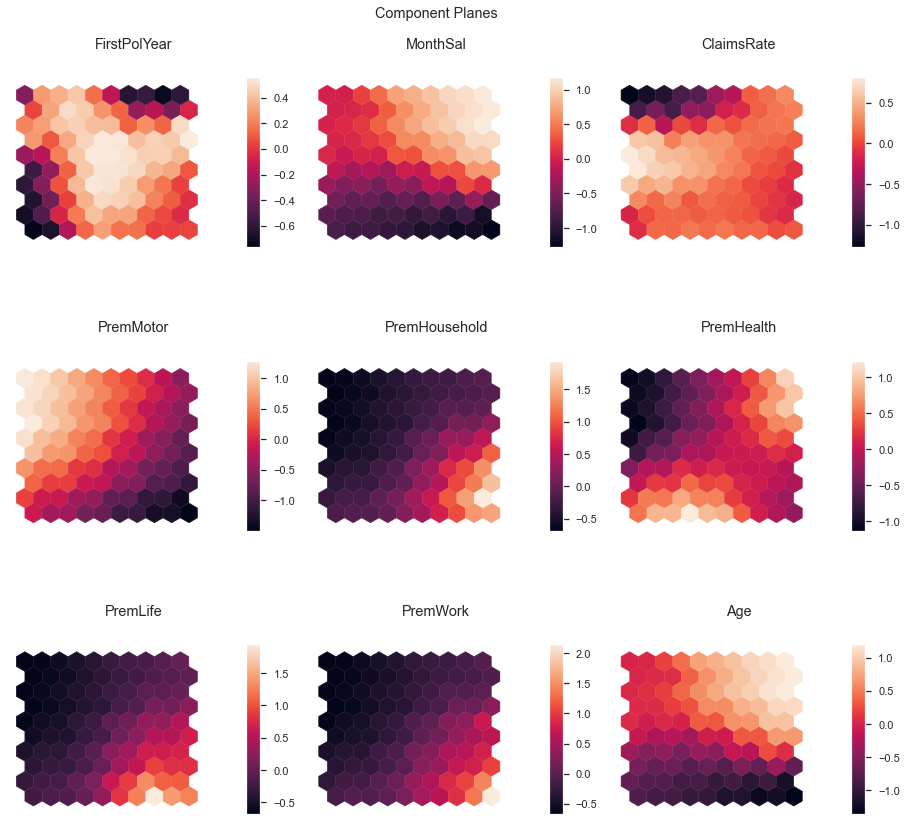

In [1153]:
plot_component_planes(weights=sm.codebook.matrix,features=metric_features,
                     M=10,N=10,
                     figsize=(12,12),figlayout=(3,3),
                     title="Component Planes",
                     cmap=sns.color_palette("rocket", as_cmap=True))


In [1154]:
# # Here you have U-matrix
# u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

# UMAT = u.show(
#     sm, 
#     distance=2,
#     row_normalized=False,
#     show_data=True, 
#     contour=True, # Visualize isomorphic curves
#     blob=True
# )

# np.flip(UMAT[1], axis=1) # U-matrix values - they match with the plot colors

In [1155]:
# vhts  = BmuHitsView(12,12,"Hits Map")
# vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
# plt.show()

---
### Split variables into perspectives
#### - Remove geolivArea because almost doesn't have correlations with any other variable
#### - Remove FirstPolYear because the SOM's units were indistinguishable on this variable

In [1156]:
#Split variables into perpectives
demographic=['Age', "EducDeg_b'1 - Basic'", "EducDeg_b'2 - High School'","EducDeg_b'3 - BSc/MSc'","EducDeg_b'4 - PhD'","Children_1"]

insurance=['ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']

metric_features.remove('FirstPolYear')

df_demo=df[demographic].copy()
df_insurance=df[insurance].copy()



##### K prototypes   https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb

K prototypes:

In [1157]:
df_cat_num_demo=df_cat_num[['EducDeg', 'GeoLivArea', 'Children', 'Age']].copy()

In [1158]:
df_cat_num_demo

EducDeg  GeoLivArea  Children       Age
CustID                                                    
1       b'2 - High School'           1         1 -0.715852
2       b'2 - High School'           4         1 -1.376860
3             b'1 - Basic'           3         0 -0.105692
4           b'3 - BSc/MSc'           4         1 -0.665006
5           b'3 - BSc/MSc'           4         1 -0.258232
...                    ...         ...       ...       ...
10292           b'4 - PhD'           2         0  0.962090
10293         b'1 - Basic'           3         0  0.809550
10294       b'3 - BSc/MSc'           1         1 -0.410772
10295         b'1 - Basic'           2         1 -0.461619
10296           b'4 - PhD'           1         1 -0.665006

[10211 rows x 4 columns]

In [1159]:
#https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb


Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 7
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 7
cost (sum distance) for all k:
2 : 8377.643
3 : 6571.717
4 : 5734.295
5 : 5196.448
6 : 4823.644
7 : 4475.034
8 : 4303.167
9 : 3986.650


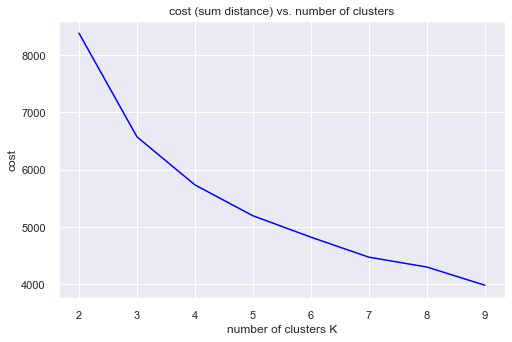

In [1160]:

# kprototypes: looking for the elbow - compare number of clusters by their cost
# cost = sum distance of all points to their respective cluster centroids

# run kPrototypes for alternative number of clusters k
dict_cost_c3 = {}
for k in (range(2,10)):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_jobs=-1, verbose=2, random_state=42)
    res = kproto.fit_predict(df_cat_num_demo, categorical=[0,1,2])
    dict_cost_c3[k] = kproto.cost_

print("cost (sum distance) for all k:")
_ = [print(k,":",f'{v:.3f}') for k,v in dict_cost_c3.items()]


# scree plot: look for elbow
plt.figure(figsize=[8,5])
plt.plot(dict_cost_c3.keys(), dict_cost_c3.values(), color="blue")
plt.title("cost (sum distance) vs. number of clusters")
plt.xticks(np.arange(2,10,1))
plt.xlabel("number of clusters K")
plt.ylabel("cost");

In [1161]:
from kneed import KneeLocator
# cost (sum distance): confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concave, will detect knees
cost_knee_c3 = KneeLocator(
        x=list(dict_cost_c3.keys()), 
        y=list(dict_cost_c3.values()), 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost_c3 = cost_knee_c3.elbow   
print("elbow at k =", f'{K_cost_c3:.0f} clusters')

elbow at k = 4 clusters


In [1162]:
# Fit the cluster
kprototype = KPrototypes(n_clusters = 4, init='Cao', n_jobs=-1, verbose=2, random_state=42)
demo_labels=kprototype.fit_predict(df_cat_num_demo, categorical = [0,1,2])

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 10


In [1163]:
# Add the cluster to the dataframe
df_cat_num_demo['Cluster Labels'] = kprototype.labels_
# df_cat_num_demo['Segment'] = df_cat_num_demo['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})
df_cat_num_demo['Segment'] = df_cat_num_demo['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third', 3: 'Fourth'})
# df_cat_num_demo['Segment'] = df_cat_num_demo['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third', 3: 'Fourth', 4: 'Fifth'})
# Order the cluster
df_cat_num_demo['Segment'] = df_cat_num_demo['Segment'].astype('category')
# df_cat_num_demo['Segment'] = df_cat_num_demo['Segment'].cat.reorder_categories(['First','Second','Third'])
df_cat_num_demo['Segment'] = df_cat_num_demo['Segment'].cat.reorder_categories(['First','Second','Third', 'Fourth'])
# df_cat_num_demo['Segment'] = df_cat_num_demo['Segment'].cat.reorder_categories(['First','Second','Third', 'Fourth', 'Fifth'])

In [1164]:
# Cluster interpretation
df_cat_num_demo.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df_cat_num_demo.groupby('Segment').agg(
    {
        'Total':'count',
        'EducDeg': lambda x: x.value_counts().index[0],
        'GeoLivArea': lambda x: x.value_counts().index[0],
        'Children': lambda x: x.value_counts().index[0],
        'Age': 'mean',
    }
).reset_index()

Segment  Total             EducDeg  GeoLivArea  Children       Age
0   First   3022      b'3 - BSc/MSc'           4         1 -0.392264
1  Second   2236  b'2 - High School'           1         1  0.400138
2   Third   2325  b'2 - High School'           1         1 -1.113551
3  Fourth   2628      b'3 - BSc/MSc'           4         0  1.079630

In [1165]:
df_cat_num_demo

EducDeg  GeoLivArea  Children       Age  Total Segment
CustID                                                                   
1       b'2 - High School'           1         1 -0.715852      2   Third
2       b'2 - High School'           4         1 -1.376860      2   Third
3             b'1 - Basic'           3         0 -0.105692      0   First
4           b'3 - BSc/MSc'           4         1 -0.665006      0   First
5           b'3 - BSc/MSc'           4         1 -0.258232      0   First
...                    ...         ...       ...       ...    ...     ...
10292           b'4 - PhD'           2         0  0.962090      3  Fourth
10293         b'1 - Basic'           3         0  0.809550      3  Fourth
10294       b'3 - BSc/MSc'           1         1 -0.410772      0   First
10295         b'1 - Basic'           2         1 -0.461619      0   First
10296           b'4 - PhD'           1         1 -0.665006      2   Third

[10211 rows x 6 columns]

In [1166]:
## VER SE EM CATEGORICAS SE USA ESTA MÉTRIC

# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_cat_num_demo)  # get total sum of squares
ssw_labels = df_cat_num_demo.groupby(by='Segment').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.5902116979467638

### K prototypes 4 clusters 
---

### Para insurance

In [1167]:
# from sklearn.mixture import GaussianMixture
# # Performing GMM clustering
# gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
# gmm_labels = gmm.fit_predict(df_insurance)
# labels_proba = gmm.predict_proba(df_insurance)

In [1168]:
# # The estimated covariance matrices of the Components
# gmm.covariances_.shape

In [1169]:
# # Selecting number of components based on AIC and BIC
# n_components = np.arange(1, 16)
# models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_insurance)
#           for n in n_components]

# bic_values = [m.bic(df_insurance) for m in models]
# aic_values = [m.aic(df_insurance) for m in models]
# plt.plot(n_components, bic_values, label='BIC')
# plt.plot(n_components, aic_values, label='AIC')
# plt.legend(loc='best')
# plt.xlabel('n_components')
# plt.xticks(n_components)
# plt.show()

In [1170]:
# # Performing GMM clustering
# gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=42)
# gmm_labels = gmm.fit_predict(df_insurance)

In [1171]:
# # Concatenating the labels to df
# df_concat = pd.concat([df_insurance, pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
# df_concat.head()

In [1172]:
# # Computing the R^2 of the cluster solution
# sst = get_ss(df_insurance)  # get total sum of squares
# ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
# ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
# r2 = ssb / sst
# print("Cluster solution with R^2 of %0.4f" % r2)

Gaussian has a R^2 of 0.4670


In [1173]:
df_insurance

ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  PremWork
CustID                                                                      
1        -0.120238   0.365331      -0.368141   -0.085775  0.133284 -0.474537
2         0.130769  -1.092446       0.588024   -0.188780  3.328255  1.295093
3        -0.158061  -0.463734       0.043713   -0.161388  0.985594  1.154102
4         0.086069  -0.579373      -0.470643    0.486393 -0.119549 -0.247484
5         0.055123   0.183445      -0.458008    0.040004 -0.478325  0.012488
...            ...        ...            ...         ...       ...       ...
10292     0.075754   0.452732      -0.453323    0.009523 -0.673312 -0.516379
10293    -0.254337  -0.818273       2.347170   -0.096572 -0.605933  1.275263
10294    -0.182130   0.501049      -0.216659   -0.100044 -0.610699 -0.712498
10295    -0.030838  -0.549523       0.005807    0.094787  0.499210  1.429541
10296    -0.161499   0.552103      -0.325550   -0.103515 -0.735924 -0.553857

[10211 rows x 6 columns]

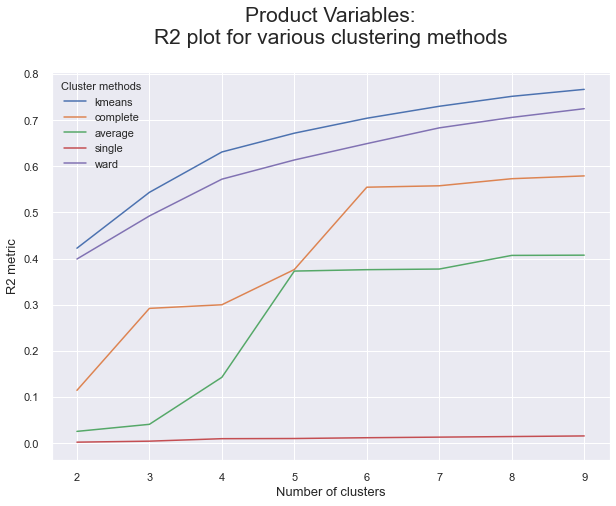

In [1174]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust
    
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_insurance, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_insurance, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Product Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

silhouette scores:
2 : 0.462
3 : 0.333
4 : 0.339
5 : 0.302
6 : 0.286
7 : 0.280
8 : 0.280
9 : 0.231
maximum silhouette score for 2 clusters:  0.462


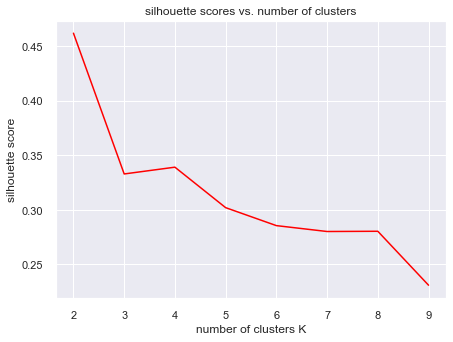

In [1175]:
from sklearn.metrics import silhouette_score
# find maximum silhouette score for up to 10 clusters
sil_scores = [silhouette_score(
                                df_insurance, 
                                KMeans(init='k-means++',n_clusters=k, random_state=42, n_init=20). \
                                fit_predict(df_insurance)) \
                                for k in (range(2,10))]

dict_sil = dict(zip(range(2,10), sil_scores))
print("silhouette scores:")
_ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
K_sil_b3 = max(dict_sil, key=dict_sil.get)            # optimal clusters
sil_opt_b3 = dict_sil[K_sil_b3]                       # optimal silhouette score
print("maximum silhouette score for", f'{K_sil_b3:.0f} clusters: ', f'{sil_opt_b3:.3f}')

plt.figure(figsize=[7,5])
plt.plot(range(2,10), sil_scores, color="red")
plt.title("silhouette scores vs. number of clusters")
plt.xticks(np.arange(2,10,1))
plt.xlabel("number of clusters K")
plt.ylabel("silhouette score")
plt.show()

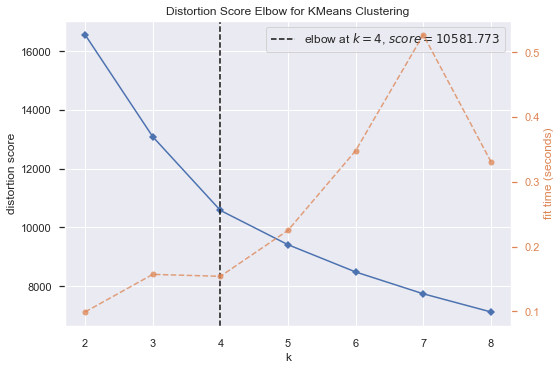

In [1176]:
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

visualizer = KElbowVisualizer(KMeans(init='k-means++', n_init=20, random_state=42), k=(2,9),ax=ax)
visualizer.fit(df_insurance)

ax.set_xticks(range(2,9))
visualizer.show()
plt.show()

### Choose k-means 4 clusters - R^2 ~ 0.55

---

Merging

In [1177]:
demo_labels

array([2, 2, 0, ..., 0, 0, 2], dtype=uint16)

In [1178]:
df_cat_num

FirstPolYear             EducDeg  MonthSal  GeoLivArea  Children  \
CustID                                                                     
1          -0.011872  b'2 - High School' -0.289077           1         1   
2          -0.019685  b'2 - High School' -1.587974           4         1   
3          -0.000152        b'1 - Basic' -0.202484           3         0   
4          -0.002105      b'3 - BSc/MSc' -1.222551           4         1   
5          -0.009918      b'3 - BSc/MSc' -0.647572           4         1   
...              ...                 ...       ...         ...       ...   
10292      -0.013825          b'4 - PhD'  0.586380           2         0   
10293      -0.027499        b'1 - Basic' -0.069130           3         0   
10294       0.005708      b'3 - BSc/MSc'  0.352578           1         1   
10295      -0.019685        b'1 - Basic' -0.467459           2         1   
10296      -0.002105          b'4 - PhD'  0.263387           1         1   

        ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
CustID                                                                         
1        -0.120238   0.365331      -0.368141   -0.085775  0.133284 -0.474537   
2         0.130769  -1.092446       0.588024   -0.188780  3.328255  1.295093   
3        -0.158061  -0.463734       0.043713   -0.161388  0.985594  1.154102   
4         0.086069  -0.579373      -0.470643    0.486393 -0.119549 -0.247484   
5         0.055123   0.183445      -0.458008    0.040004 -0.478325  0.012488   
...            ...        ...            ...         ...       ...       ...   
10292     0.075754   0.452732      -0.453323    0.009523 -0.673312 -0.516379   
10293    -0.254337  -0.818273       2.347170   -0.096572 -0.605933  1.275263   
10294    -0.182130   0.501049      -0.216659   -0.100044 -0.610699 -0.712498   
10295    -0.030838  -0.549523       0.005807    0.094787  0.499210  1.429541   
10296    -0.161499   0.552103      -0.325550   -0.103515 -0.735924 -0.553857   

             Age  
CustID            
1      -0.715852  
2      -1.376860  
3      -0.105692  
4      -0.665006  
5      -0.258232  
...          ...  
10292   0.962090  
10293   0.809550  
10294  -0.410772  
10295  -0.461619  
10296  -0.665006  

[10211 rows x 12 columns]

In [1179]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_insurance = KMeans(init='k-means++', n_init=20, random_state=42, n_clusters=4)
insurance_labels = kmeans_insurance.fit_predict(df_insurance)



df_cat_num['insurance_labels'] = insurance_labels
df_cat_num['demo_labels'] = demo_labels
df=df_cat_num.copy()

In [1180]:
# Count label frequencies (contigency table)
df.groupby(['insurance_labels', 'demo_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('demo_labels', 'insurance_labels', 0)

insurance_labels     0     1    2    3
demo_labels                           
0                  853  1993   99   77
1                  744  1288  100  104
2                  883   357  548  537
3                 1347   985  157  139

merging small clusters using hierarchical

In [1181]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['demo_labels', 'insurance_labels'])\
    [metric_features].mean()
df_centroids

MonthSal  ClaimsRate  PremMotor  PremHousehold  \
demo_labels insurance_labels                                                   
0           0                -0.545828   -0.009280  -0.247975       0.034255   
            1                -0.266726   -0.036478   0.651904      -0.426147   
            2                -0.621525   -0.019932  -0.603689       0.456374   
            3                -0.576499   -0.017710  -0.709866       0.491360   
1           0                 0.470350   -0.014413  -0.168480       0.153101   
            1                 0.274638   -0.034832   0.673140      -0.385373   
            2                 0.440695    0.006641  -0.546808       0.385730   
            3                 0.504782   -0.028028  -0.615916       0.433784   
2           0                -0.891406   -0.015429  -0.446365       0.214643   
            1                -0.709337   -0.020821   0.379894      -0.356070   
            2                -1.162296   -0.006004  -1.038815       0.851067   
            3                -1.178506   -0.012730  -1.045117       0.976678   
3           0                 1.007735   -0.006948  -0.375313       0.071654   
            1                 0.910495   -0.023151   0.405279      -0.369520   
            2                 0.933194   -0.003309  -0.782370       0.467543   
            3                 1.023781   -0.009663  -0.801544       0.468131   

                              PremHealth  PremLife  PremWork       Age  
demo_labels insurance_labels                                            
0           0                   0.140888  0.011004  0.035045 -0.580837  
            1                  -0.176067 -0.652039 -0.591687 -0.290480  
            2                  -0.055984  1.995988  0.173075 -0.625972  
            3                   0.002896  0.165909  1.901256 -0.637271  
1           0                   0.021680  0.141736  0.103356  0.507271  
            1                  -0.222210 -0.587794 -0.534048  0.321887  
            2                  -0.067492  1.949239  0.110188  0.469385  
            3                  -0.088995  0.401904  1.944938  0.536249  
2           0                   0.211169  0.072052  0.116607 -1.000087  
            1                  -0.029170 -0.589912 -0.514549 -0.821249  
            2                  -0.011992  2.600229  0.608677 -1.309034  
            3                  -0.034717  0.665540  2.364600 -1.294956  
3           0                   0.215941  0.037584  0.022860  1.105533  
            1                  -0.045266 -0.565029 -0.510602  1.033224  
            2                   0.057621  2.090445  0.145065  1.113011  
            3                   0.084656  0.261753  1.795078  1.119752

In [1182]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

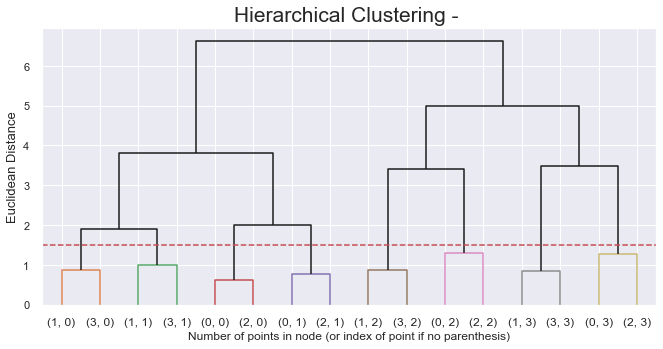

In [1183]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 1.5
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - ', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [1195]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=8
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

MonthSal  ClaimsRate  PremMotor  PremHousehold  \
demo_labels insurance_labels                                                   
0           0                -0.545828   -0.009280  -0.247975       0.034255   
            1                -0.266726   -0.036478   0.651904      -0.426147   
            2                -0.621525   -0.019932  -0.603689       0.456374   
            3                -0.576499   -0.017710  -0.709866       0.491360   
1           0                 0.470350   -0.014413  -0.168480       0.153101   
            1                 0.274638   -0.034832   0.673140      -0.385373   
            2                 0.440695    0.006641  -0.546808       0.385730   
            3                 0.504782   -0.028028  -0.615916       0.433784   
2           0                -0.891406   -0.015429  -0.446365       0.214643   
            1                -0.709337   -0.020821   0.379894      -0.356070   
            2                -1.162296   -0.006004  -1.038815       0.851067   
            3                -1.178506   -0.012730  -1.045117       0.976678   
3           0                 1.007735   -0.006948  -0.375313       0.071654   
            1                 0.910495   -0.023151   0.405279      -0.369520   
            2                 0.933194   -0.003309  -0.782370       0.467543   
            3                 1.023781   -0.009663  -0.801544       0.468131   

                              PremHealth  PremLife  PremWork       Age  \
demo_labels insurance_labels                                             
0           0                   0.140888  0.011004  0.035045 -0.580837   
            1                  -0.176067 -0.652039 -0.591687 -0.290480   
            2                  -0.055984  1.995988  0.173075 -0.625972   
            3                   0.002896  0.165909  1.901256 -0.637271   
1           0                   0.021680  0.141736  0.103356  0.507271   
            1                  -0.222210 -0.587794 -0.534048  0.321887   
            2                  -0.067492  1.949239  0.110188  0.469385   
            3                  -0.088995  0.401904  1.944938  0.536249   
2           0                   0.211169  0.072052  0.116607 -1.000087   
            1                  -0.029170 -0.589912 -0.514549 -0.821249   
            2                  -0.011992  2.600229  0.608677 -1.309034   
            3                  -0.034717  0.665540  2.364600 -1.294956   
3           0                   0.215941  0.037584  0.022860  1.105533   
            1                  -0.045266 -0.565029 -0.510602  1.033224   
            2                   0.057621  2.090445  0.145065  1.113011   
            3                   0.084656  0.261753  1.795078  1.119752   

                              hclust_labels  
demo_labels insurance_labels                 
0           0                             4  
            1                             7  
            2                             0  
            3                             2  
1           0                             3  
            1                             1  
            2                             5  
            3                             6  
2           0                             4  
            1                             7  
            2                             0  
            3                             2  
3           0                             3  
            1                             1  
            2                             5  
            3                             6

In [1196]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['demo_labels'], row['insurance_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

MonthSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
merged_labels                                                               
0             -1.079550   -0.008135  -0.972235       0.790673   -0.018723   
1              0.550185   -0.029770   0.557063      -0.378503   -0.145531   
2             -1.103010   -0.013355  -1.003074       0.915816   -0.030000   
3              0.816528   -0.009604  -0.301720       0.100634    0.146821   
4             -0.721603   -0.012408  -0.348884       0.126008    0.176636   
5              0.741560    0.000563  -0.690712       0.435709    0.008939   
6              0.801658   -0.017523  -0.722098       0.453431    0.010336   
7             -0.333965   -0.034100   0.610582      -0.415501   -0.153751   

               PremLife  PremWork       Age  
merged_labels                                
0              2.507772  0.542024 -1.204516  
1             -0.577929 -0.523888  0.630143  
2              0.602882  2.306494 -1.212478  
3              0.074642  0.051501  0.892665  
4              0.042056  0.076531 -0.794085  
5              2.035501  0.131494  0.862573  
6              0.321735  1.859216  0.870022  
7             -0.642601 -0.579969 -0.371112

In [1197]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['demo_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['insurance_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('demo_labels', 'insurance_labels', 0)

insurance_labels     0     1    2    3
demo_labels                           
2                 1736  2350  647  614
3                 2091  2273  257  243

In [1198]:
# Setting df to have the final product, behavior and merged clusters
df = df_.copy()

In [1199]:
df

FirstPolYear             EducDeg  MonthSal  GeoLivArea  Children  \
CustID                                                                     
1          -0.011872  b'2 - High School' -0.289077           1         1   
2          -0.019685  b'2 - High School' -1.587974           4         1   
3          -0.000152        b'1 - Basic' -0.202484           3         0   
4          -0.002105      b'3 - BSc/MSc' -1.222551           4         1   
5          -0.009918      b'3 - BSc/MSc' -0.647572           4         1   
...              ...                 ...       ...         ...       ...   
10292      -0.013825          b'4 - PhD'  0.586380           2         0   
10293      -0.027499        b'1 - Basic' -0.069130           3         0   
10294       0.005708      b'3 - BSc/MSc'  0.352578           1         1   
10295      -0.019685        b'1 - Basic' -0.467459           2         1   
10296      -0.002105          b'4 - PhD'  0.263387           1         1   

        ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
CustID                                                                         
1        -0.120238   0.365331      -0.368141   -0.085775  0.133284 -0.474537   
2         0.130769  -1.092446       0.588024   -0.188780  3.328255  1.295093   
3        -0.158061  -0.463734       0.043713   -0.161388  0.985594  1.154102   
4         0.086069  -0.579373      -0.470643    0.486393 -0.119549 -0.247484   
5         0.055123   0.183445      -0.458008    0.040004 -0.478325  0.012488   
...            ...        ...            ...         ...       ...       ...   
10292     0.075754   0.452732      -0.453323    0.009523 -0.673312 -0.516379   
10293    -0.254337  -0.818273       2.347170   -0.096572 -0.605933  1.275263   
10294    -0.182130   0.501049      -0.216659   -0.100044 -0.610699 -0.712498   
10295    -0.030838  -0.549523       0.005807    0.094787  0.499210  1.429541   
10296    -0.161499   0.552103      -0.325550   -0.103515 -0.735924 -0.553857   

             Age  insurance_labels  demo_labels  merged_labels  
CustID                                                          
1      -0.715852                 1            2              7  
2      -1.376860                 2            2              0  
3      -0.105692                 3            0              2  
4      -0.665006                 0            0              4  
5      -0.258232                 1            0              7  
...          ...               ...          ...            ...  
10292   0.962090                 1            3              1  
10293   0.809550                 3            3              6  
10294  -0.410772                 1            0              7  
10295  -0.461619                 3            0              2  
10296  -0.665006                 1            2              7  

[10211 rows x 15 columns]

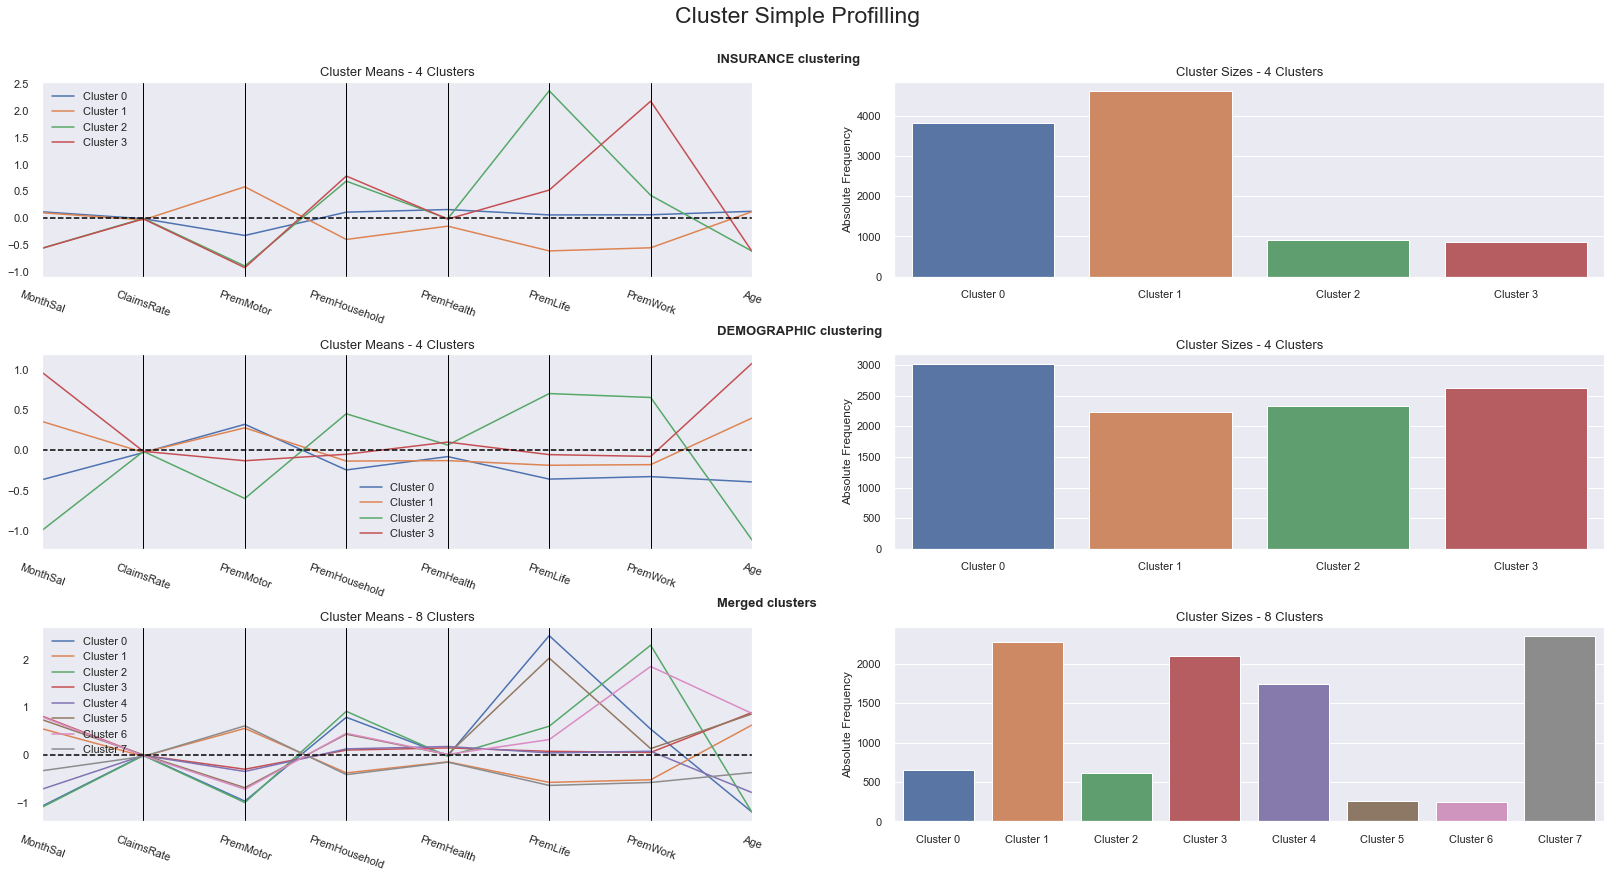

In [1200]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features + ['insurance_labels', 'demo_labels', 'merged_labels']], 
    label_columns = ['insurance_labels', 'demo_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["INSURANCE clustering", "DEMOGRAPHIC clustering", "Merged clusters"]
)

In [1201]:
# Characterizing the final clusters
df_means = df.groupby('merged_labels').mean().copy()
df_means= df_means[metric_features]
df_means

MonthSal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
merged_labels                                                               
0             -1.079550   -0.008135  -0.972235       0.790673   -0.018723   
1              0.550185   -0.029770   0.557063      -0.378503   -0.145531   
2             -1.103010   -0.013355  -1.003074       0.915816   -0.030000   
3              0.816528   -0.009604  -0.301720       0.100634    0.146821   
4             -0.721603   -0.012408  -0.348884       0.126008    0.176636   
5              0.741560    0.000563  -0.690712       0.435709    0.008939   
6              0.801658   -0.017523  -0.722098       0.453431    0.010336   
7             -0.333965   -0.034100   0.610582      -0.415501   -0.153751   

               PremLife  PremWork       Age  
merged_labels                                
0              2.507772  0.542024 -1.204516  
1             -0.577929 -0.523888  0.630143  
2              0.602882  2.306494 -1.212478  
3              0.074642  0.051501  0.892665  
4              0.042056  0.076531 -0.794085  
5              2.035501  0.131494  0.862573  
6              0.321735  1.859216  0.870022  
7             -0.642601 -0.579969 -0.371112

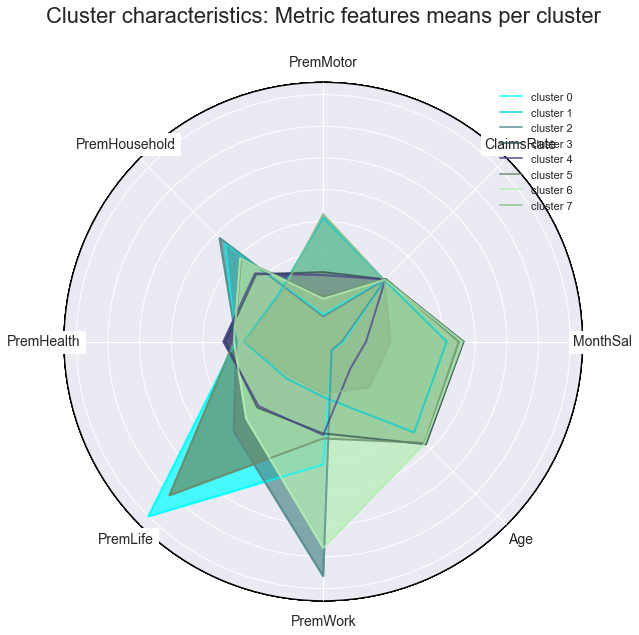

In [1202]:
cluster_colors = ['#00FFFF', '#00CED1', '#528B8B', '#2F4F4F', '#483D8B', '#698B69', '#B4EEB4', '#8FBC8F']

class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)
        
        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]
        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14, backgroundcolor="white",zorder=999) # Feature names
        self.ax.set_yticklabels([])
        
        for ax in self.axes[1:]:
            ax.xaxis.set_visible(False)
            ax.set_yticklabels([])
            ax.set_zorder(-99)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.spines['polar'].set_color('black')
            ax.spines['polar'].set_zorder(-99)
                     
    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        kw['label'] = '_noLabel'
        self.ax.fill(angle, values,*args,**kw)

fig = plt.figure(figsize=(8, 8))
no_features = len(metric_features)
radar = Radar(fig, metric_features, np.unique(df['merged_labels']))

for k in range(0,len(np.unique(df['merged_labels']))):
    cluster_data = df_means.T[k].values.tolist()
    radar.plot(cluster_data,  '-', lw=2, color=cluster_colors[k], alpha=0.7, label='cluster {}'.format(k))

radar.ax.legend()
radar.ax.set_title("Cluster characteristics: Metric features means per cluster", size=22, pad=60)
plt.show()

In [1203]:
# helper function: pie charts for categorical variables
def cluster_pies(df):
    
    # number of categorical variables
    c = 3
    
    # number of clusters
    K = df["merged_labels"].nunique()

    for k in (range(K)):
        dfc = df[df["merged_labels"]==k]
        # chrg = dfc["MonthlyCharges"].median()
        # ten = dfc["tenure"].median()
        cases = dfc.shape[0]

        fig = plt.figure(figsize=(50, 12))
        fig.suptitle("Cluster " + str(k) + ": " + \
            f'{cases:,.0f}' + " cases")


        ax1 = plt.subplot2grid((2,c),(0,0))
        plt.pie(dfc["EducDeg"].value_counts(), labels=dfc["EducDeg"].unique(), autopct='%1.1f%%')
        plt.title("EducDeg");

        ax1 = plt.subplot2grid((2,c),(0,1))
        plt.pie(dfc["Children"].value_counts(), labels=dfc["Children"].unique(), autopct='%1.1f%%')
        plt.title("Children");

        ax1 = plt.subplot2grid((2,c),(0,2))
        plt.pie(dfc["GeoLivArea"].value_counts(), labels=dfc["GeoLivArea"].unique(), autopct='%1.1f%%')
        plt.title("GeoLivArea");

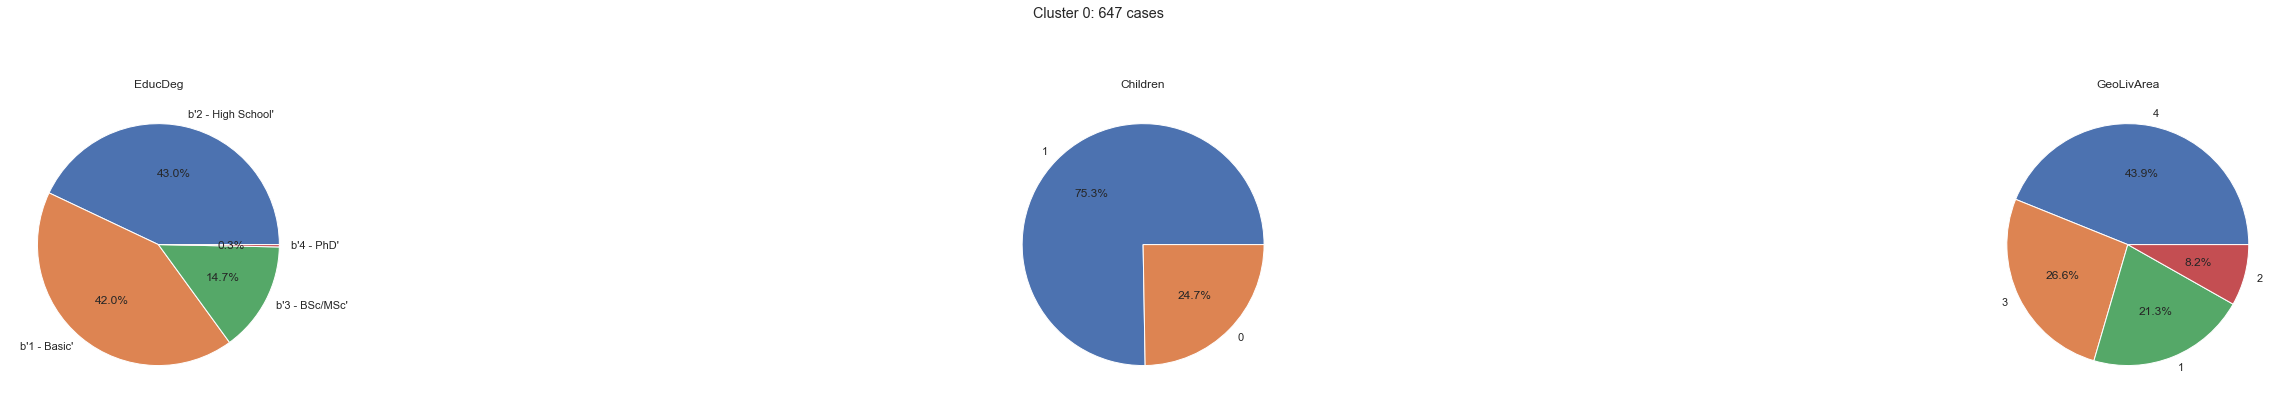

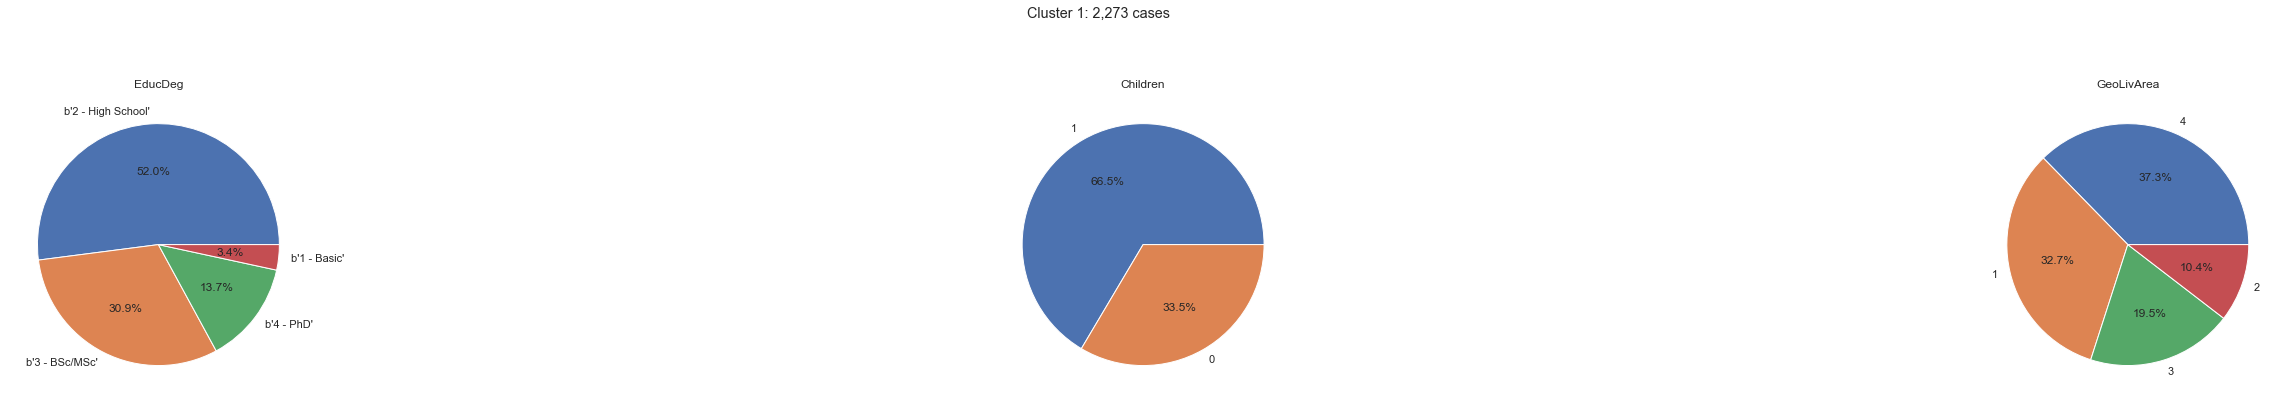

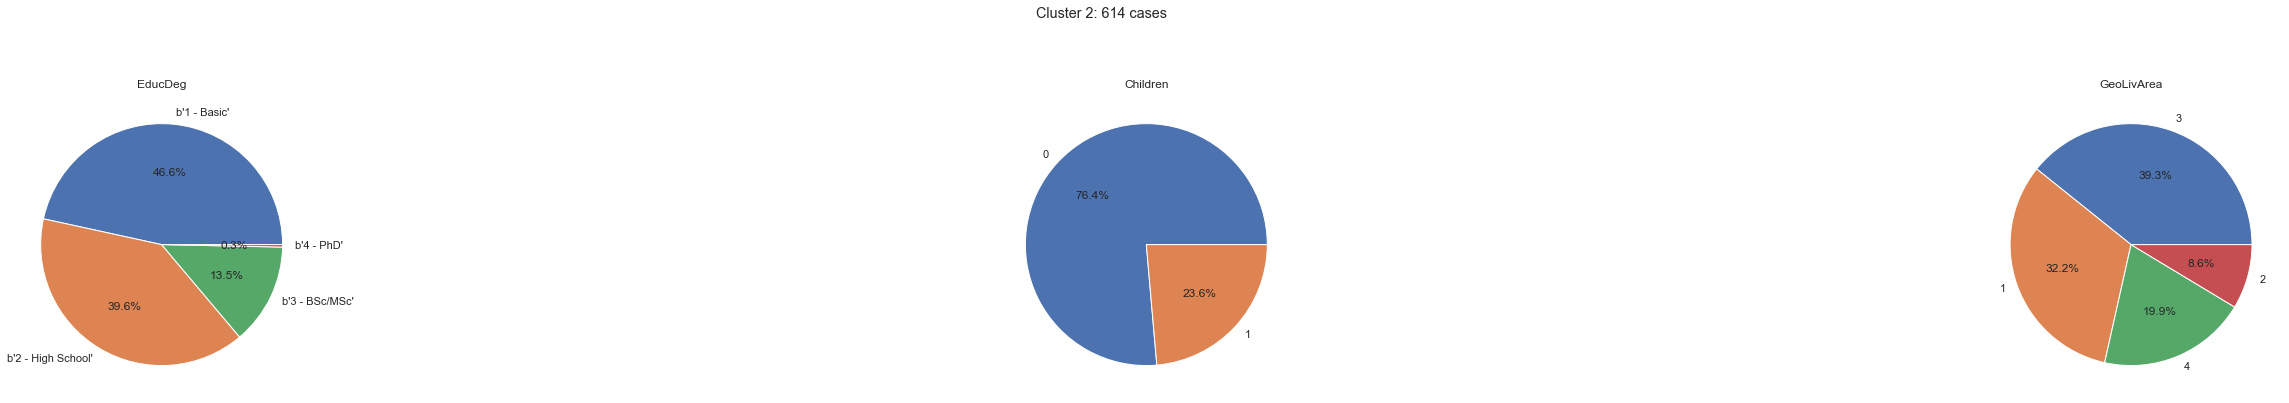

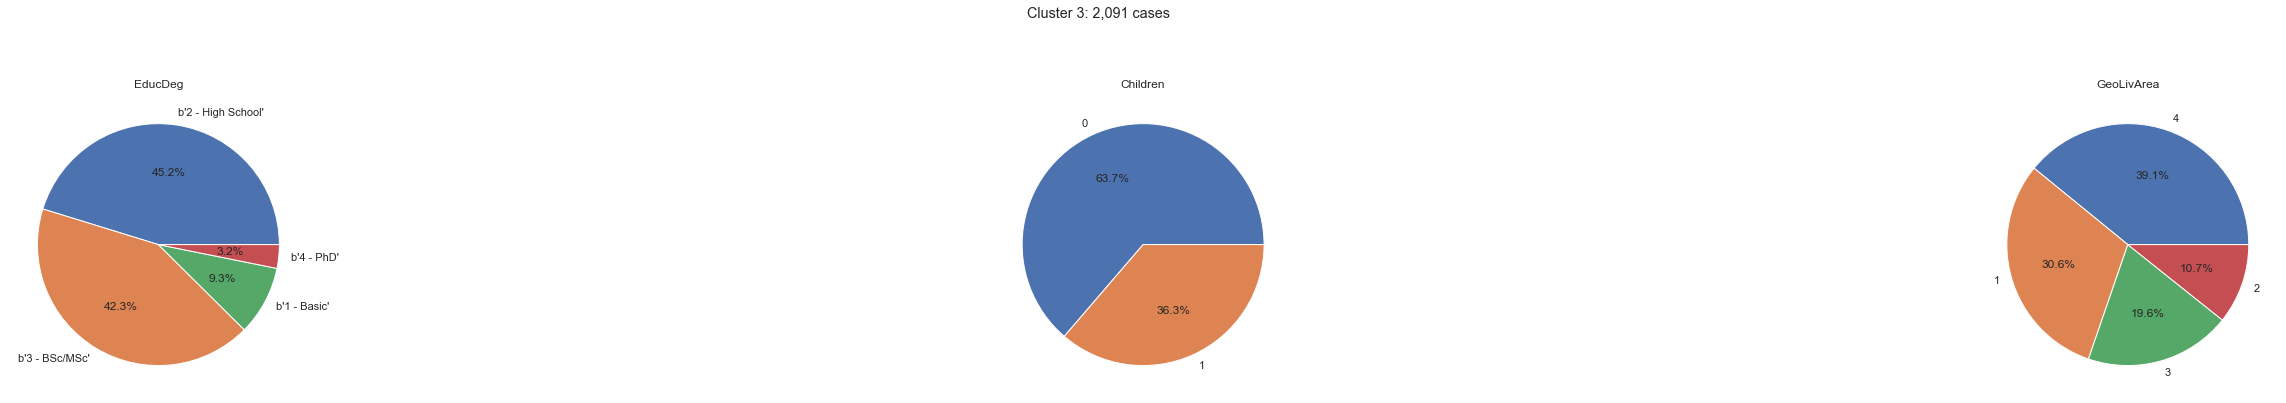

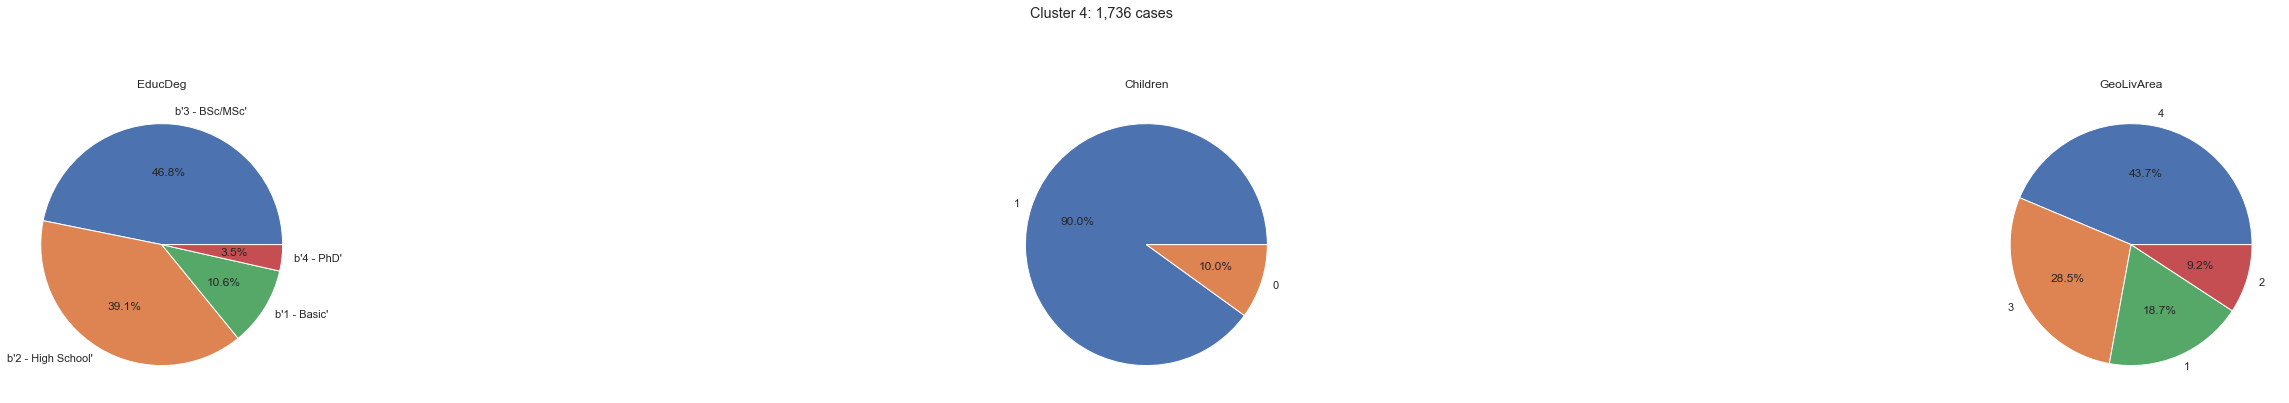

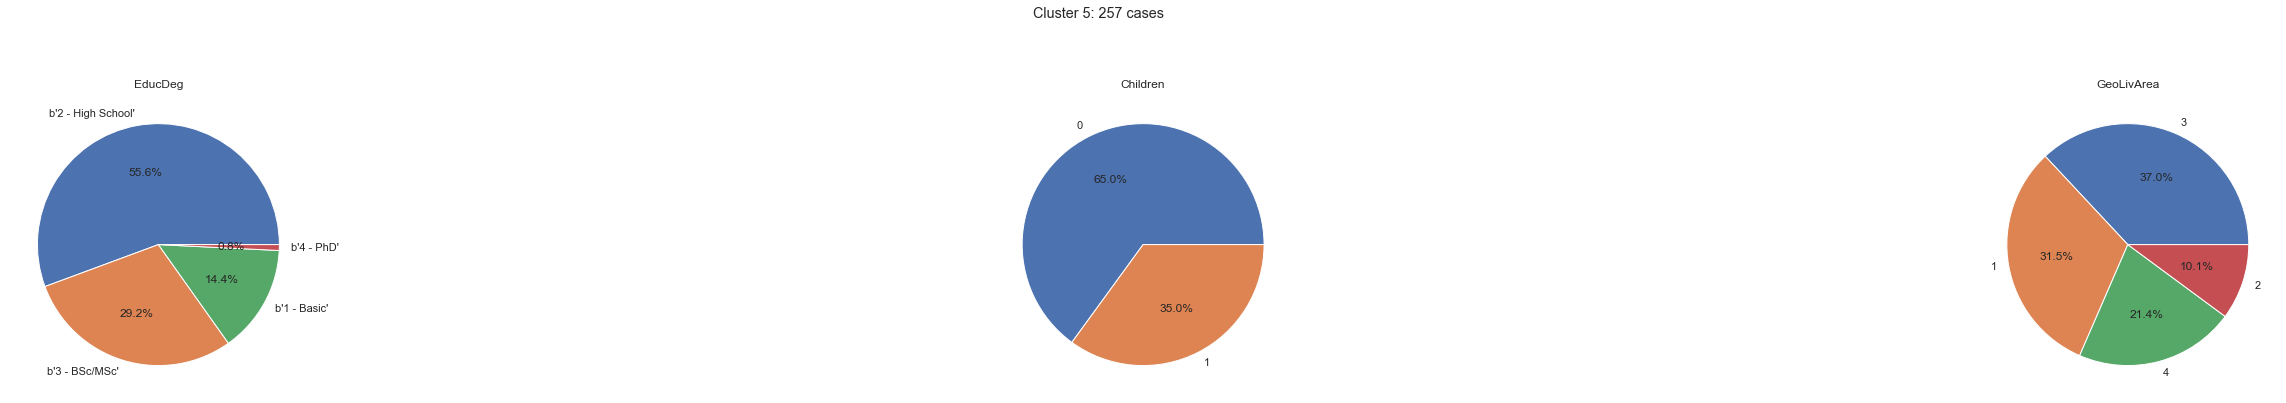

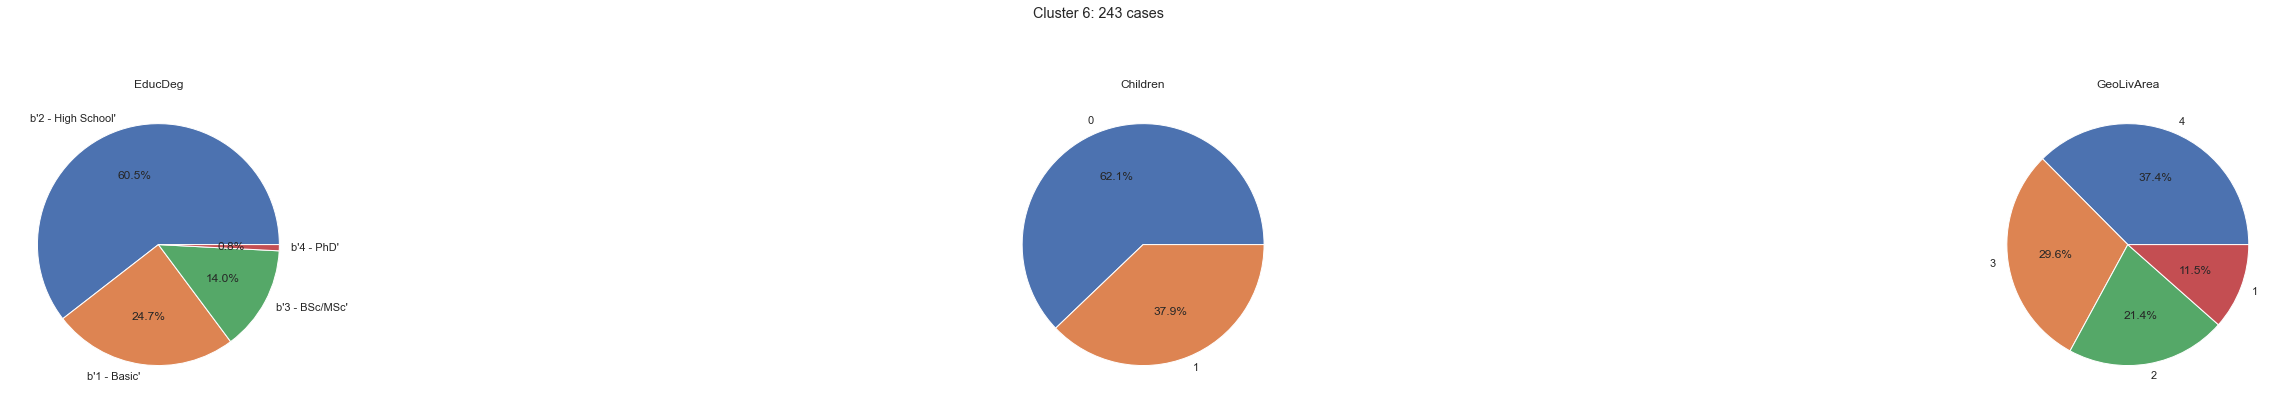

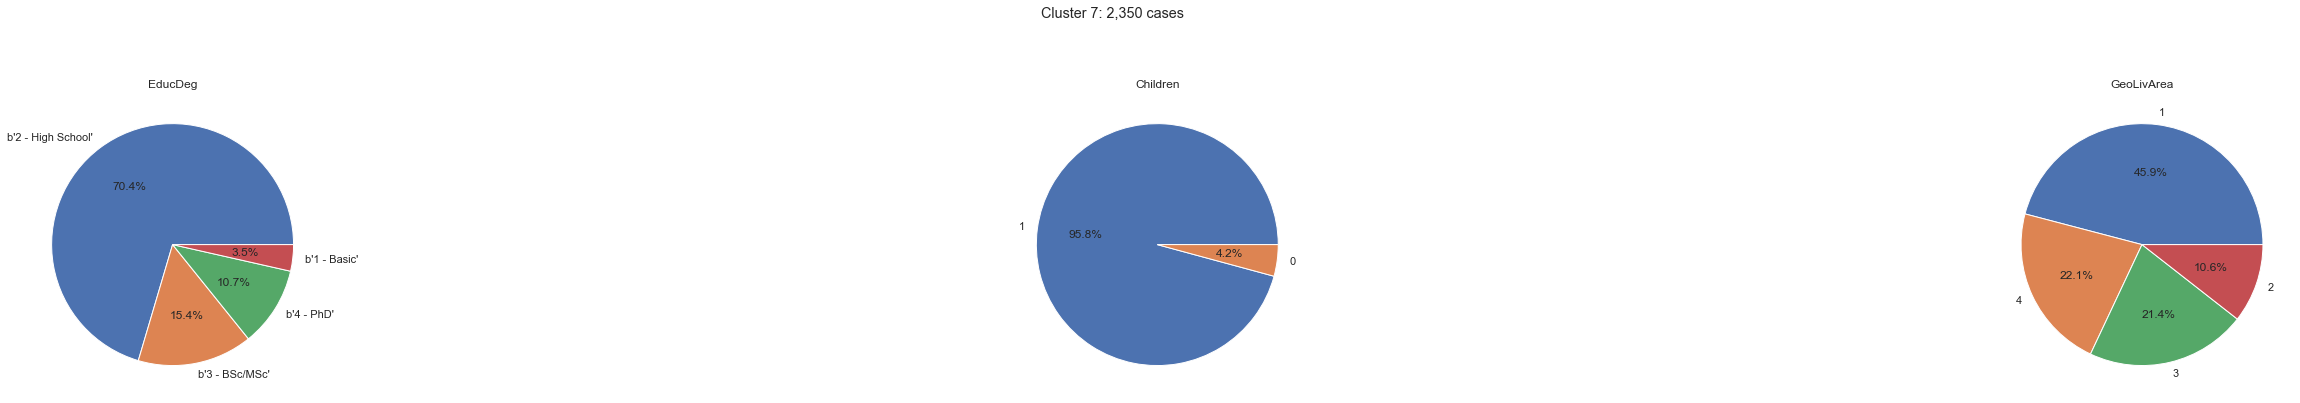

In [1204]:
cluster_pies(df)

### T-SNE

In [1205]:
from sklearn.manifold import TSNE
# This is step can be quite time consuming
two_dim = TSNE(random_state=42, perplexity=300).fit_transform(df[metric_features])

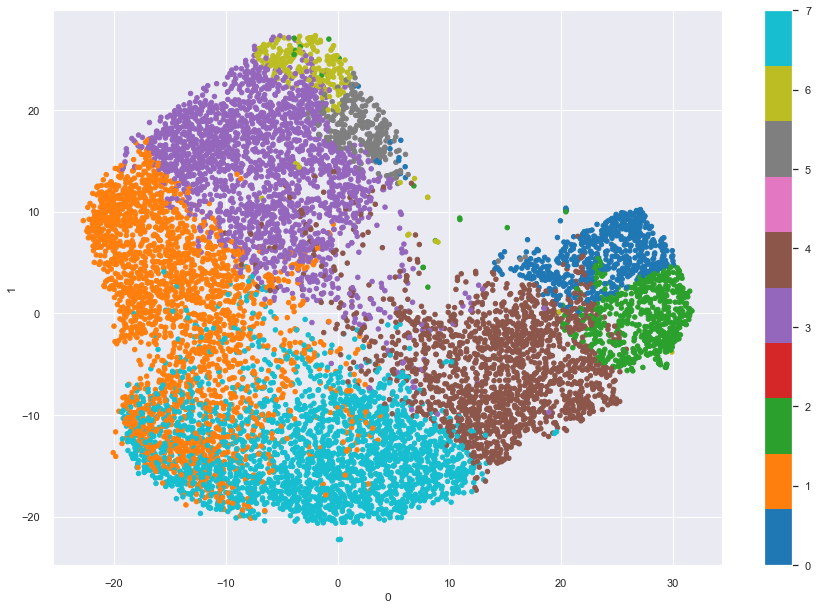

In [1206]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

### Feature Importance

In [1207]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars


In [1208]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels')

MonthSal         0.685239
ClaimsRate       0.009609
PremMotor        0.752481
PremHousehold    0.399263
PremHealth       0.299759
PremLife         0.697698
PremWork         0.670002
Age              0.782271
dtype: float64

In [1229]:

# Preparing the data
X = df[metric_features]
y = df.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=8
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=9)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 87.86% of the customers correctly


### UMAP

In [1210]:
def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    
    # Concatenate X and y arrays
    arr_concat=pd.concat([pd.DataFrame(X, index=y.index),y],axis=1)
    arr_concat.columns = ['x', 'y', 'z', 'label']
    # Create a Pandas dataframe using the above array
    df=arr_concat.copy()
    # Convert label data type from float to integer
    # df['label'] = int(df['label'])
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    #--------------------------------------------------------------------------#
    
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(title_text='UMAP',
                      showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
    
    fig.show()

> #### UMAP all data

In [1211]:
# Configure UMAP hyperparameters
reducer = UMAP.UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
              )

# Fit and transform the data
X_trans = reducer.fit_transform(X)

# Check the shape of the new data
print('Shape of X_trans: ', X_trans.shape)

Shape of X_trans:  (10211, 3)


In [1212]:
chart(X_trans, y)

> #### UMAP train test data

In [1213]:
# Configure UMAP hyperparameters
reducer2 = UMAP.UMAP(n_neighbors=100, n_components=3, n_epochs=1000, 
                min_dist=0.8, random_state=42, local_connectivity=4
              )

# Training on MNIST digits data - this time we also pass the true labels to a fit_transform method
X_train_res = reducer2.fit_transform(X_train, y_train)

# Apply on a test set
X_test_res = reducer2.transform(X_test)

# Print the shape of new arrays
print('Shape of X_train_res: ', X_train_res.shape)
print('Shape of X_test_res: ', X_test_res.shape)

Shape of X_train_res:  (8168, 3)
Shape of X_test_res:  (2043, 3)


In [1214]:
chart(X_train_res, y_train)

In [1215]:
#To check if UMAP could successfully place new data points into these clusters
chart(X_test_res, y_test)

In [1216]:
# Predicting the cluster labels of the outliers
df_out['merged_labels'] = dt.predict(df_out[metric_features])
df_out.head()

FirstPolYear  MonthSal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                                 
52         -0.017732  0.626213    8.465556   1.252484      -0.536943   
113         0.011568 -0.135807    5.126827   1.061364      -0.581095   
136         0.011568 -0.289943    4.834560  -0.016908      -0.131478   
150        -0.004058 -1.322133   -0.037715  -1.153807      -0.033661   
172        -0.002105 -1.233808   87.838589   0.376177      -0.369703   

        PremHealth  PremLife  PremWork       Age  EducDeg_b'1 - Basic'  \
CustID                                                                   
52       -0.491268 -0.776872 -0.987936  0.097695                   0.0   
113      -0.399824 -0.800920 -0.593517 -0.563312                   0.0   
136      -0.096190  2.071455 -0.868956 -1.020933                   0.0   
150      -0.491268 -0.483091  8.144381 -1.326013                   1.0   
172      -0.014779 -0.735924 -0.443603 -1.071780                   0.0   

        EducDeg_b'2 - High School'  EducDeg_b'3 - BSc/MSc'  \
CustID                                                       
52                             0.0                     1.0   
113                            0.0                     0.0   
136                            0.0                     1.0   
150                            0.0                     0.0   
172                            0.0                     1.0   

        EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  GeoLivArea_2  \
CustID                                                               
52                     0.0         1.0           0.0           0.0   
113                    1.0         1.0           1.0           0.0   
136                    0.0         1.0           0.0           0.0   
150                    0.0         1.0           0.0           0.0   
172                    0.0         1.0           0.0           0.0   

        GeoLivArea_3  GeoLivArea_4  merged_labels  
CustID                                             
52               0.0           1.0              1  
113              0.0           0.0              7  
136              0.0           1.0              0  
150              0.0           1.0              2  
172              0.0           1.0              7

In [1217]:
out_labels=pd.DataFrame(df_out.merged_labels.value_counts())
out_labels.columns=[ '#']
out_labels.index.name = 'Cluster'
out_labels

#
Cluster   
1        8
3        5
7        4
2        4
4        4
0        2

## VER SE NO UMAP SE JUNTA AS VARIAVEIS CATEGORICAS

### Decision Tree

In [1218]:
# # Visualizing the decision tree
# dot_data = export_graphviz(dt, out_file=None, 
#                            feature_names=X.columns.to_list(),
#                            filled=True,
#                            rounded=True,
#                            special_characters=True)  
# graphviz.Source(dot_data)

---


#### --- Usei Robust Scaler, mas no hierarchical está a criar um cluster com 3 elementos
### - K-prototypes
### - Criar 2 tipos de clusters antes do SOMs
### - Fazer t_SNE / UMAP
### - Colocar imports todos no inicio
### - Apesar de nao se usar as categoricas na criacao de clusters, é importante no final mostrar a sua distribuicao dentro do cluster
### - FirstPolYear nao devia ser a idade com que se fez o primeiro seguro. E pode entrar nas demograficas
### - Retirar outliers obvios, fill missing, remover outliers (DBSCAN, ou os outros tmb)
### - SOMS é data exploration para retirar alguma variavel, e pode ser usado depois em clustering